In [0]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
import sys
import json
import numpy as np 
from json import JSONDecodeError  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.cbook import boxplot_stats
from scipy.stats import iqr
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


-Converted the release date column to a datetime 64 dtype

-Sorted data by release date

-Deleted irrelevant columns 

-Checking and removing duplicate songs. Using the trackID column. Every song has a unique ID defined by spotify

-The index for the dataframe has been set as the release date


In [0]:
#data = pd.read_csv('/content/drive/My Drive/mldm_cw/datasets/billboard_1950-2019_revised.csv')


data = pd.read_csv('billboard_1950-2019_revised.csv')
data['release_date']=pd.to_datetime(data['release_date'])
data = data.sort_values(by='release_date',ascending=True)
del data['Unnamed: 0']
data.drop_duplicates(subset ="trackID", keep = False, inplace = True) 
data['release_date'] = data['release_date'] + pd.to_timedelta(data.groupby('release_date').cumcount(),unit='hour')
data.drop_duplicates(subset ="release_date", keep = False, inplace = True) 
data.dropna(inplace=True)
data.set_index('release_date')
cols = data.columns.tolist()
cols = [cols[-1]]+cols[0:len(cols)-1]
data = data[cols]
data = data.rename(columns={"acoustincess": "acousticness"})
data.index = data.release_date
rows = data.shape[0]
columns = data.shape[1]
print('dataset contains '+str(rows)+' rows')
print('dataset contains '+str(columns)+' columns')



dataset contains 5759 rows
dataset contains 20 columns


In [0]:
data.head()

,release_date,year,artistName,trackName,trackID,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,chart_position
release_date,,,,,,,,,,,,,,,,,,,,
1950-01-01 00:00:00,1950-01-01 00:00:00,1950,Nat King Cole,Mona Lisa,5dae01pKNjRQtgOeAkFzPY,0.952,0.241,194987,0.237,0.000000,1,0.1130,-12.201,1,0.0371,174.578,3,0.303,52,2
1950-01-01 01:00:00,1950-01-01 01:00:00,1950,Anton Karas,Third Man Theme,7kixCGSpKVDPF7nOqfWQcx,0.866,0.487,133520,0.499,0.876000,6,0.0746,-7.402,1,0.0381,89.824,4,0.830,32,3
1950-01-01 02:00:00,1950-01-01 02:00:00,1950,Gary and Bing Crosby,Simple Melody,3NsgqlBDPkc2YojsXDglq1,0.754,0.633,172973,0.199,0.000000,5,0.2030,-15.180,1,0.0451,138.315,3,0.785,0,5
1950-01-01 03:00:00,1950-01-01 03:00:00,1950,Teresa Brewer,"Music, Music, Music",4LVy2nxwMiuL4XfqxdyypN,0.202,0.753,172173,0.582,0.000004,2,0.1270,-8.110,1,0.0373,97.874,4,0.886,23,6
1950-01-01 04:00:00,1950-01-01 04:00:00,1950,Billy Eckstine,My Foolish Heart,4UnRb3Fmb8F2h2a1xKj6uK,0.993,0.218,183573,0.186,0.141000,9,0.3790,-13.342,1,0.0382,170.877,4,0.113,20,28


Plotting line plots to see the variation of our variables over the time to see if there is an underlying trend within the data.

Producing Box plots for every numerical variable to see the change through the years.
Identify outliers too.

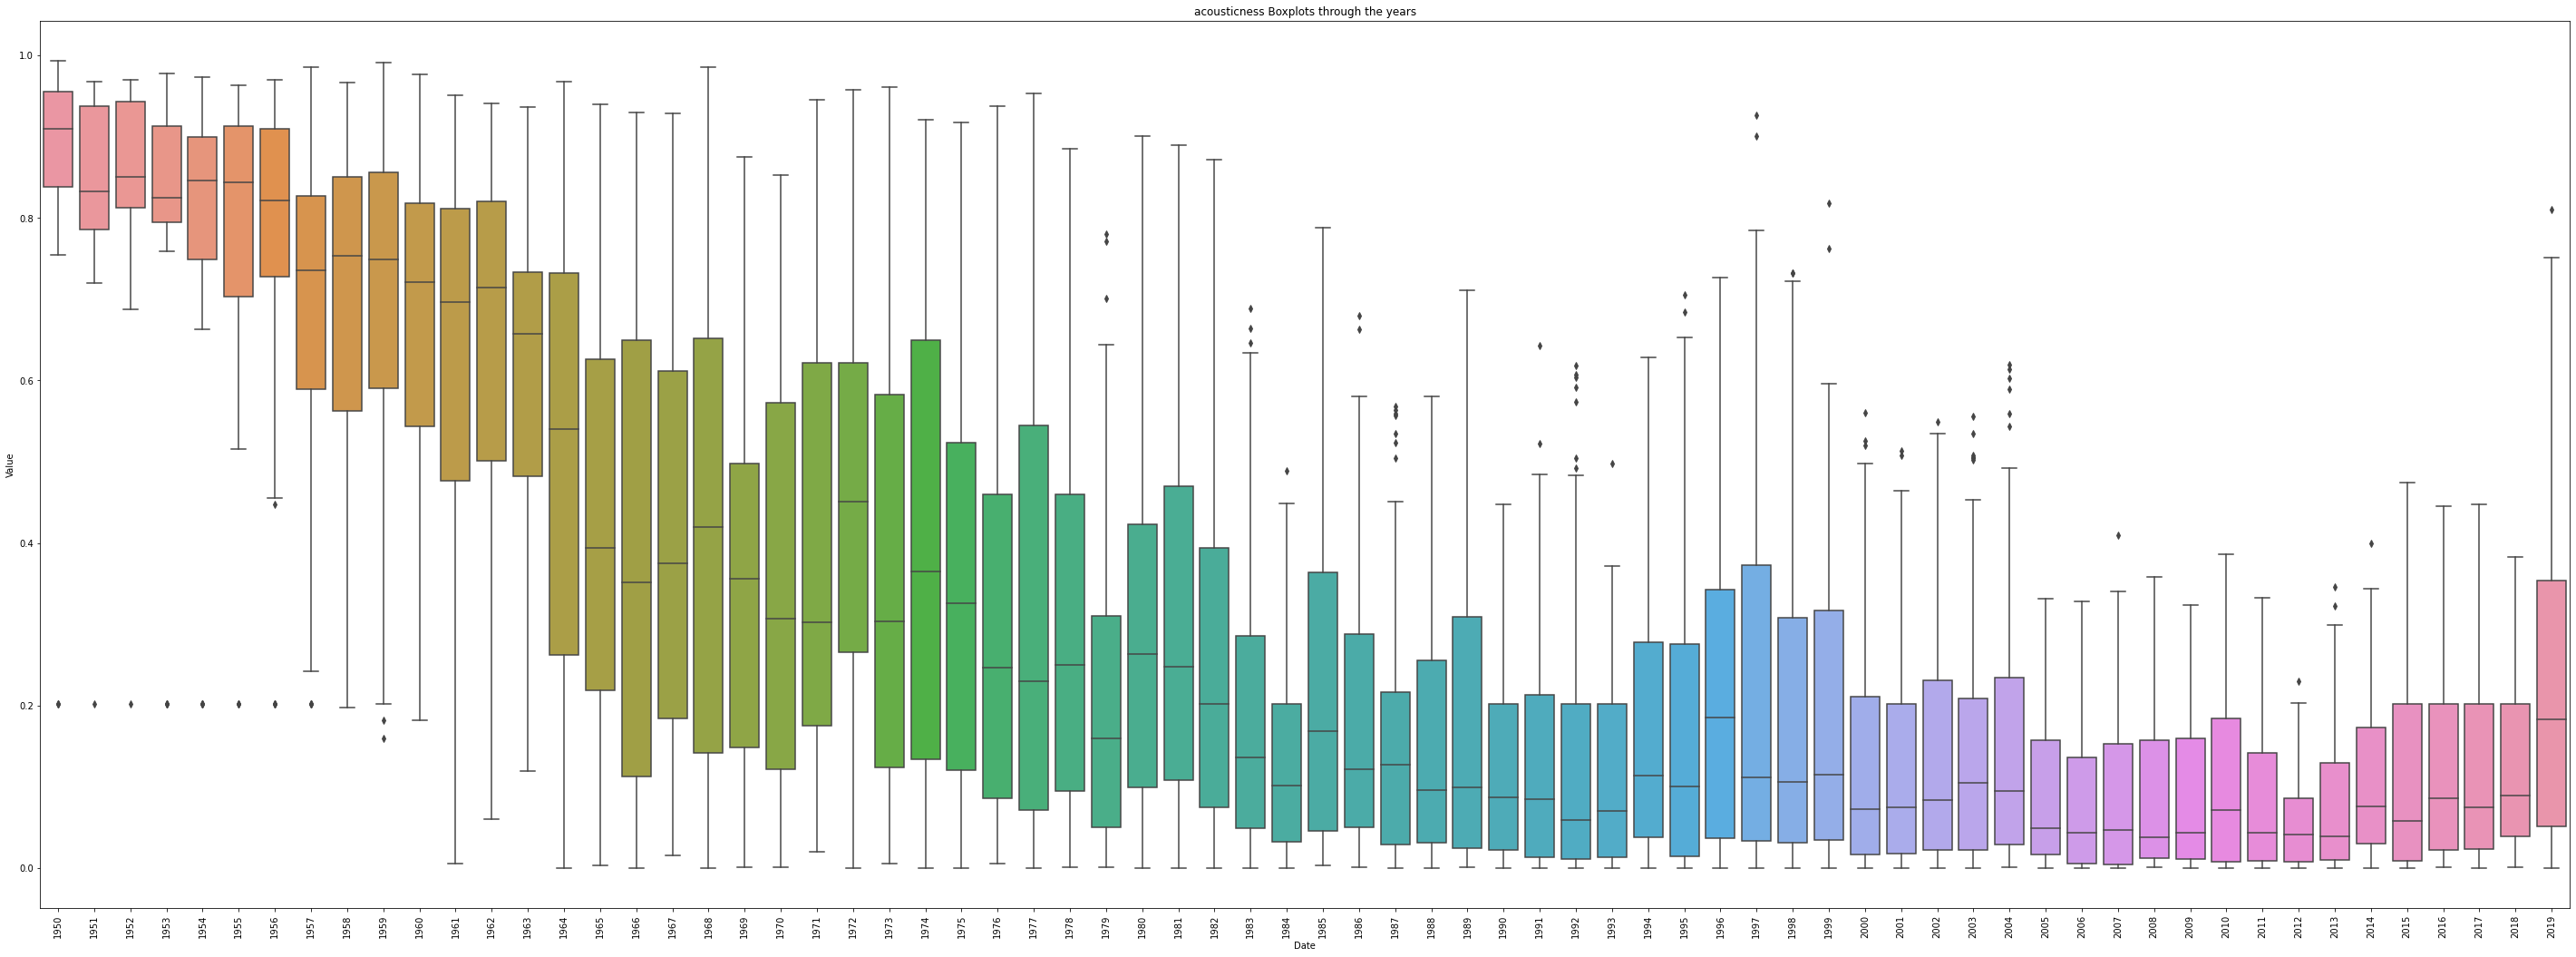

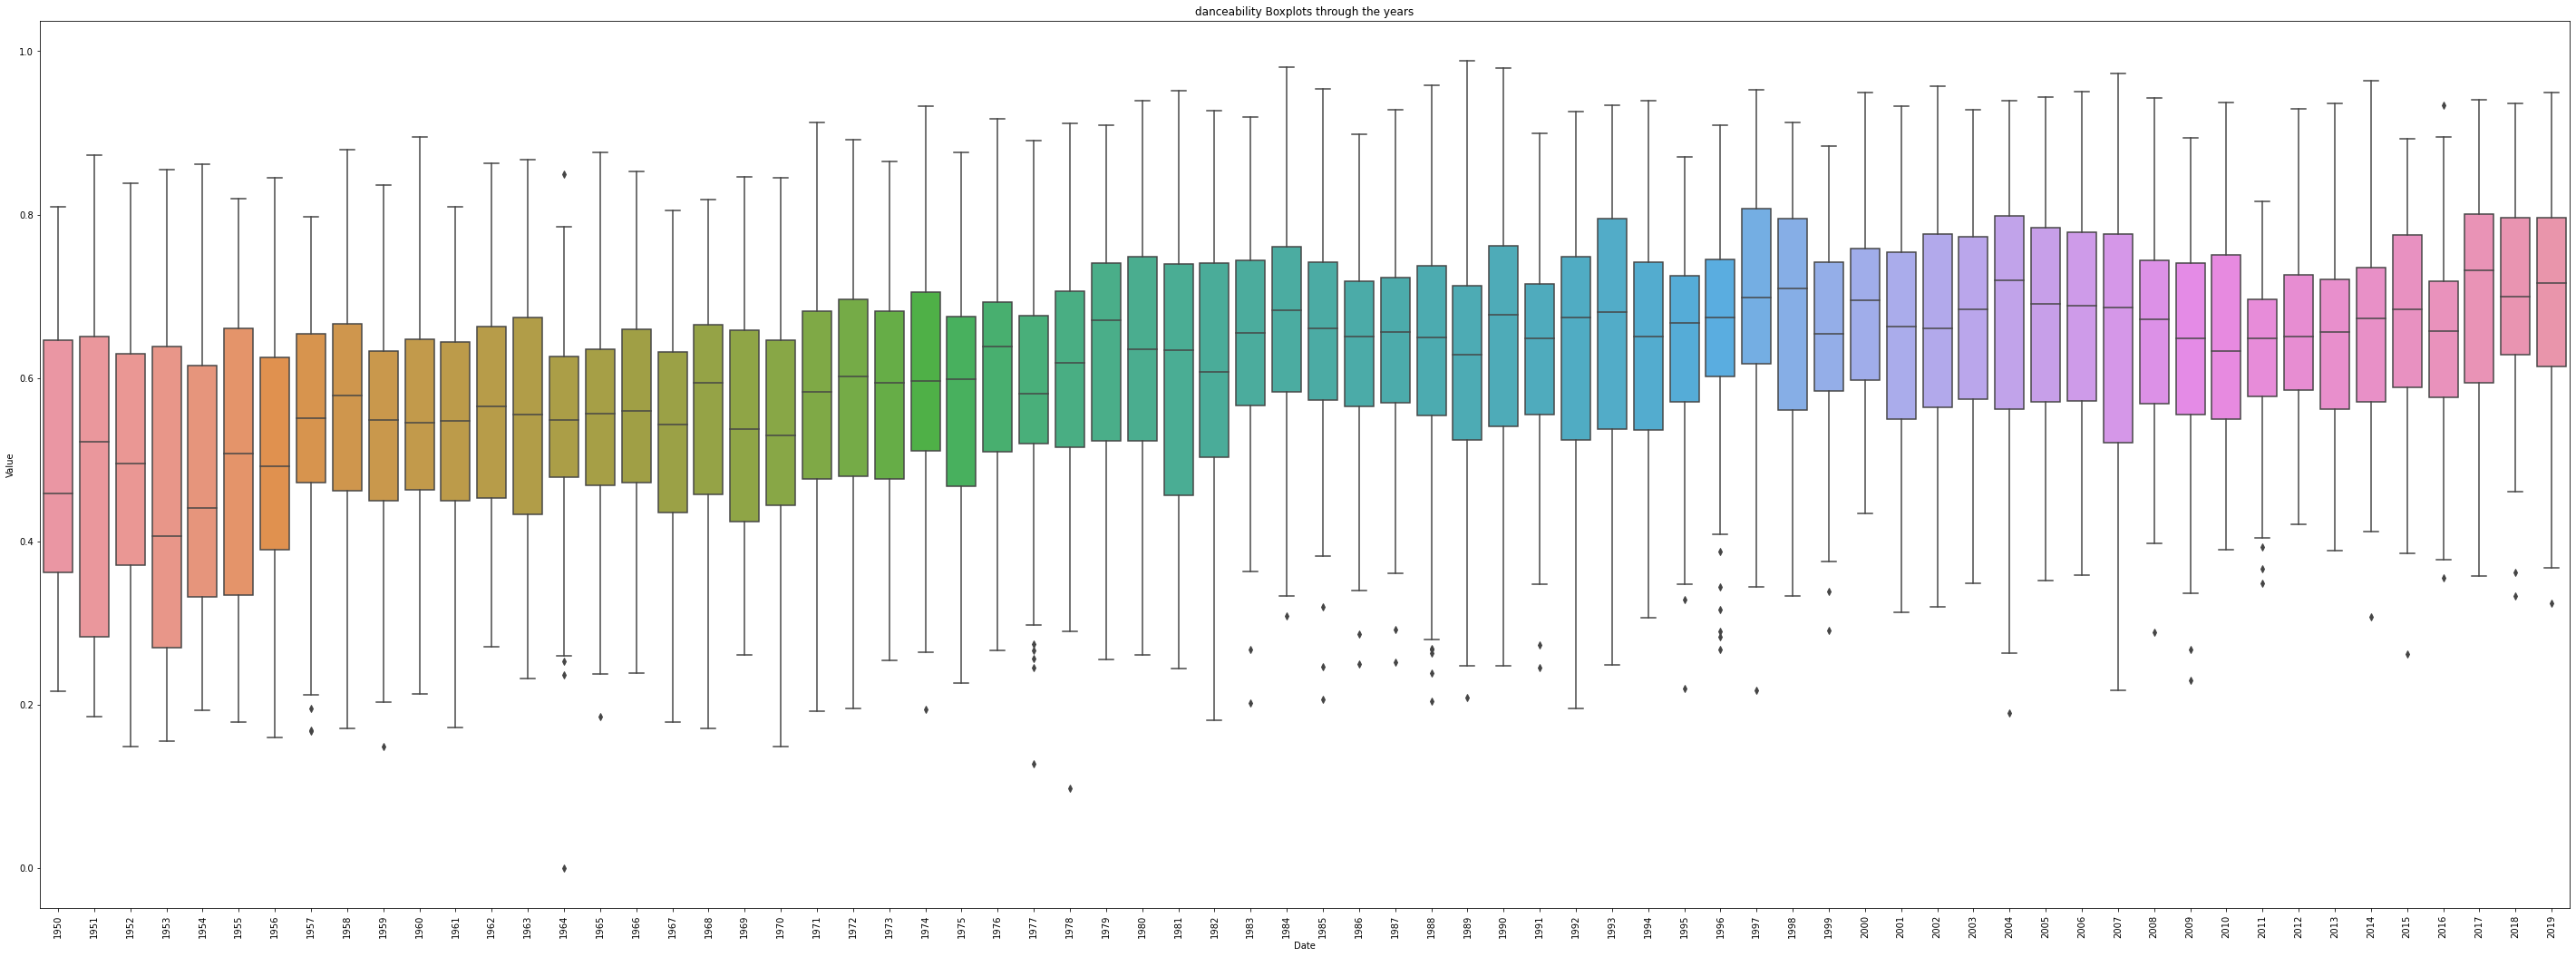

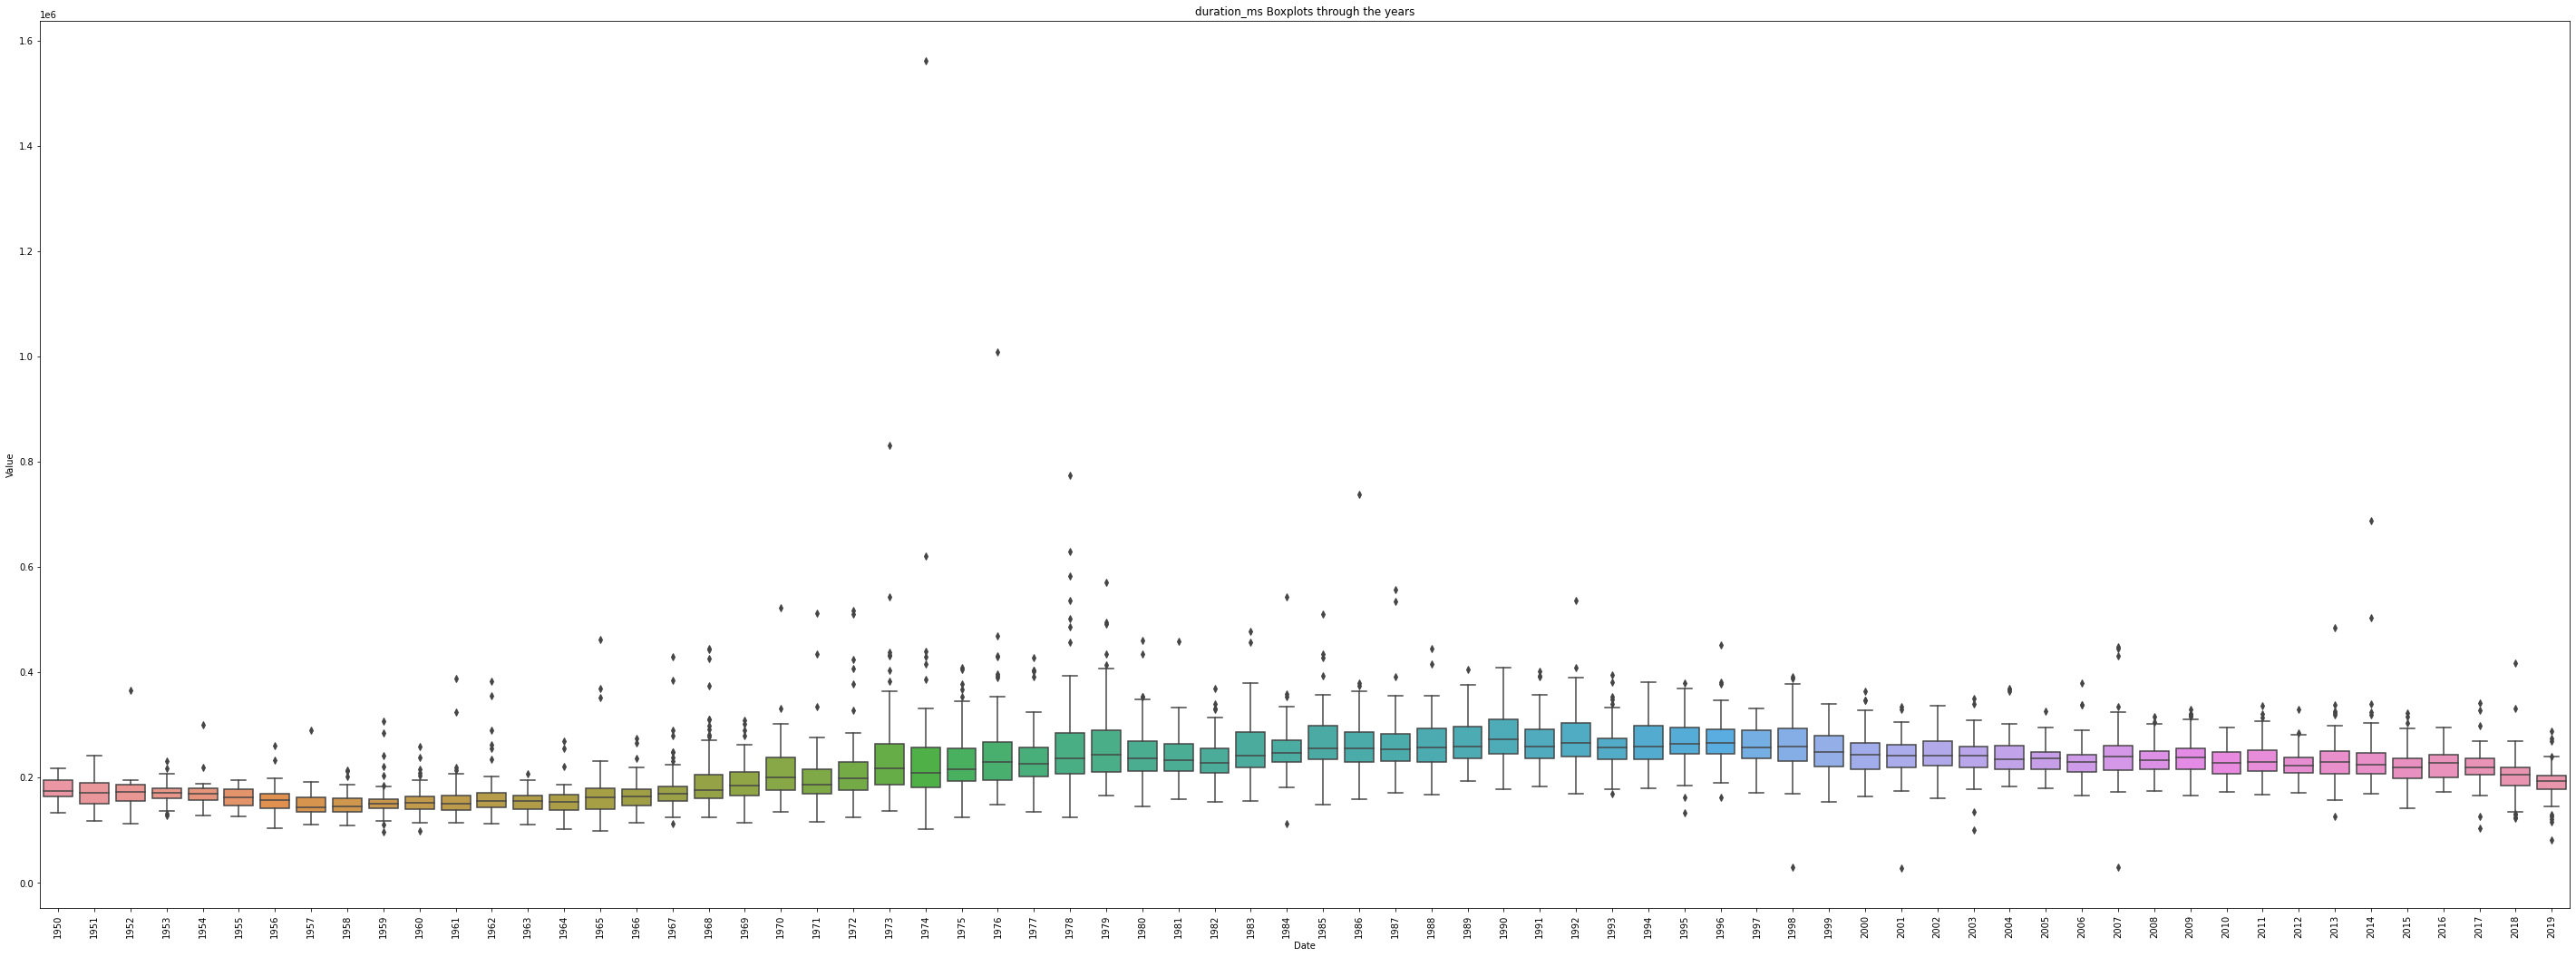

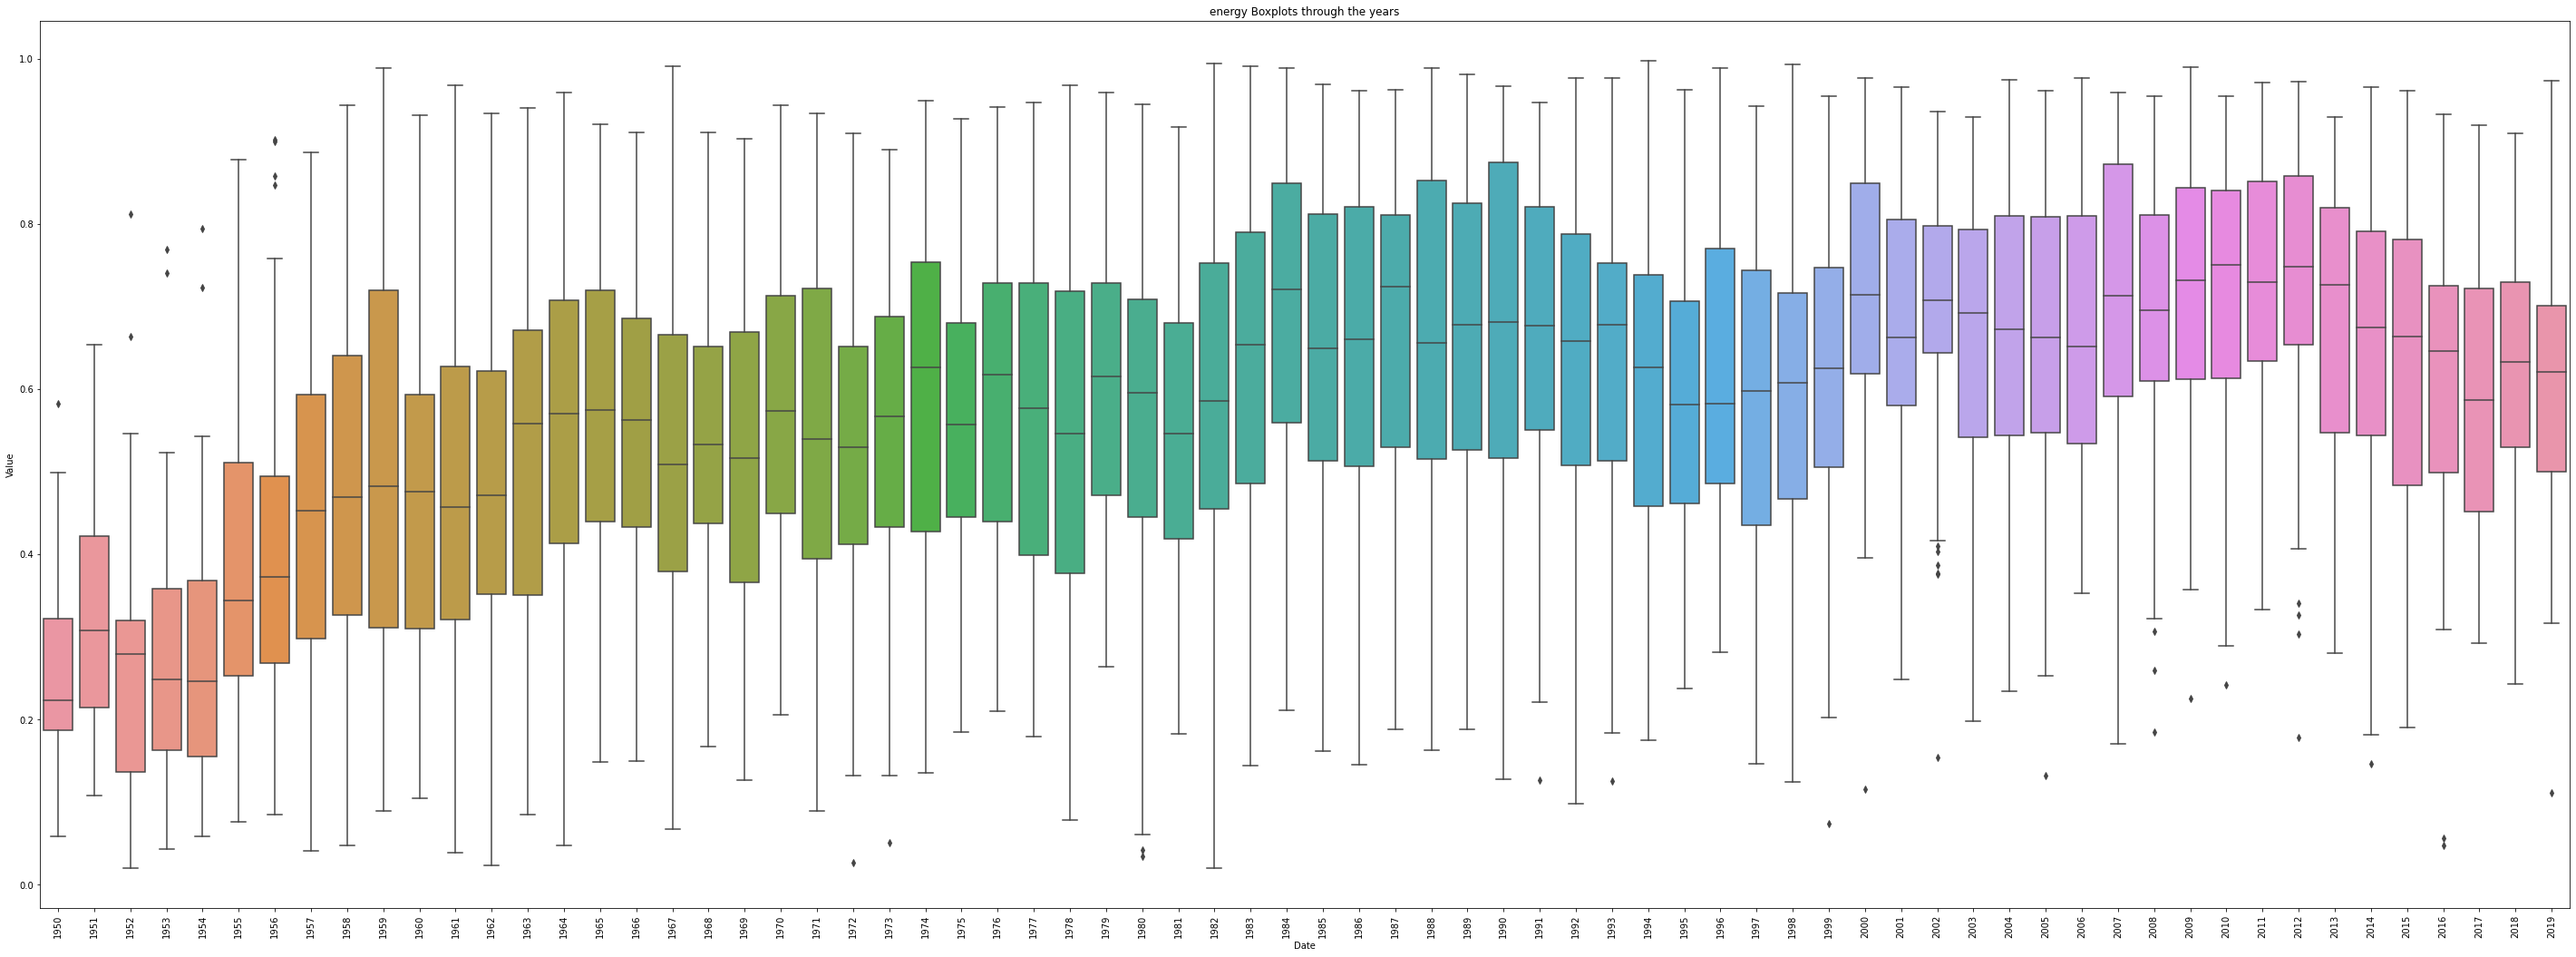

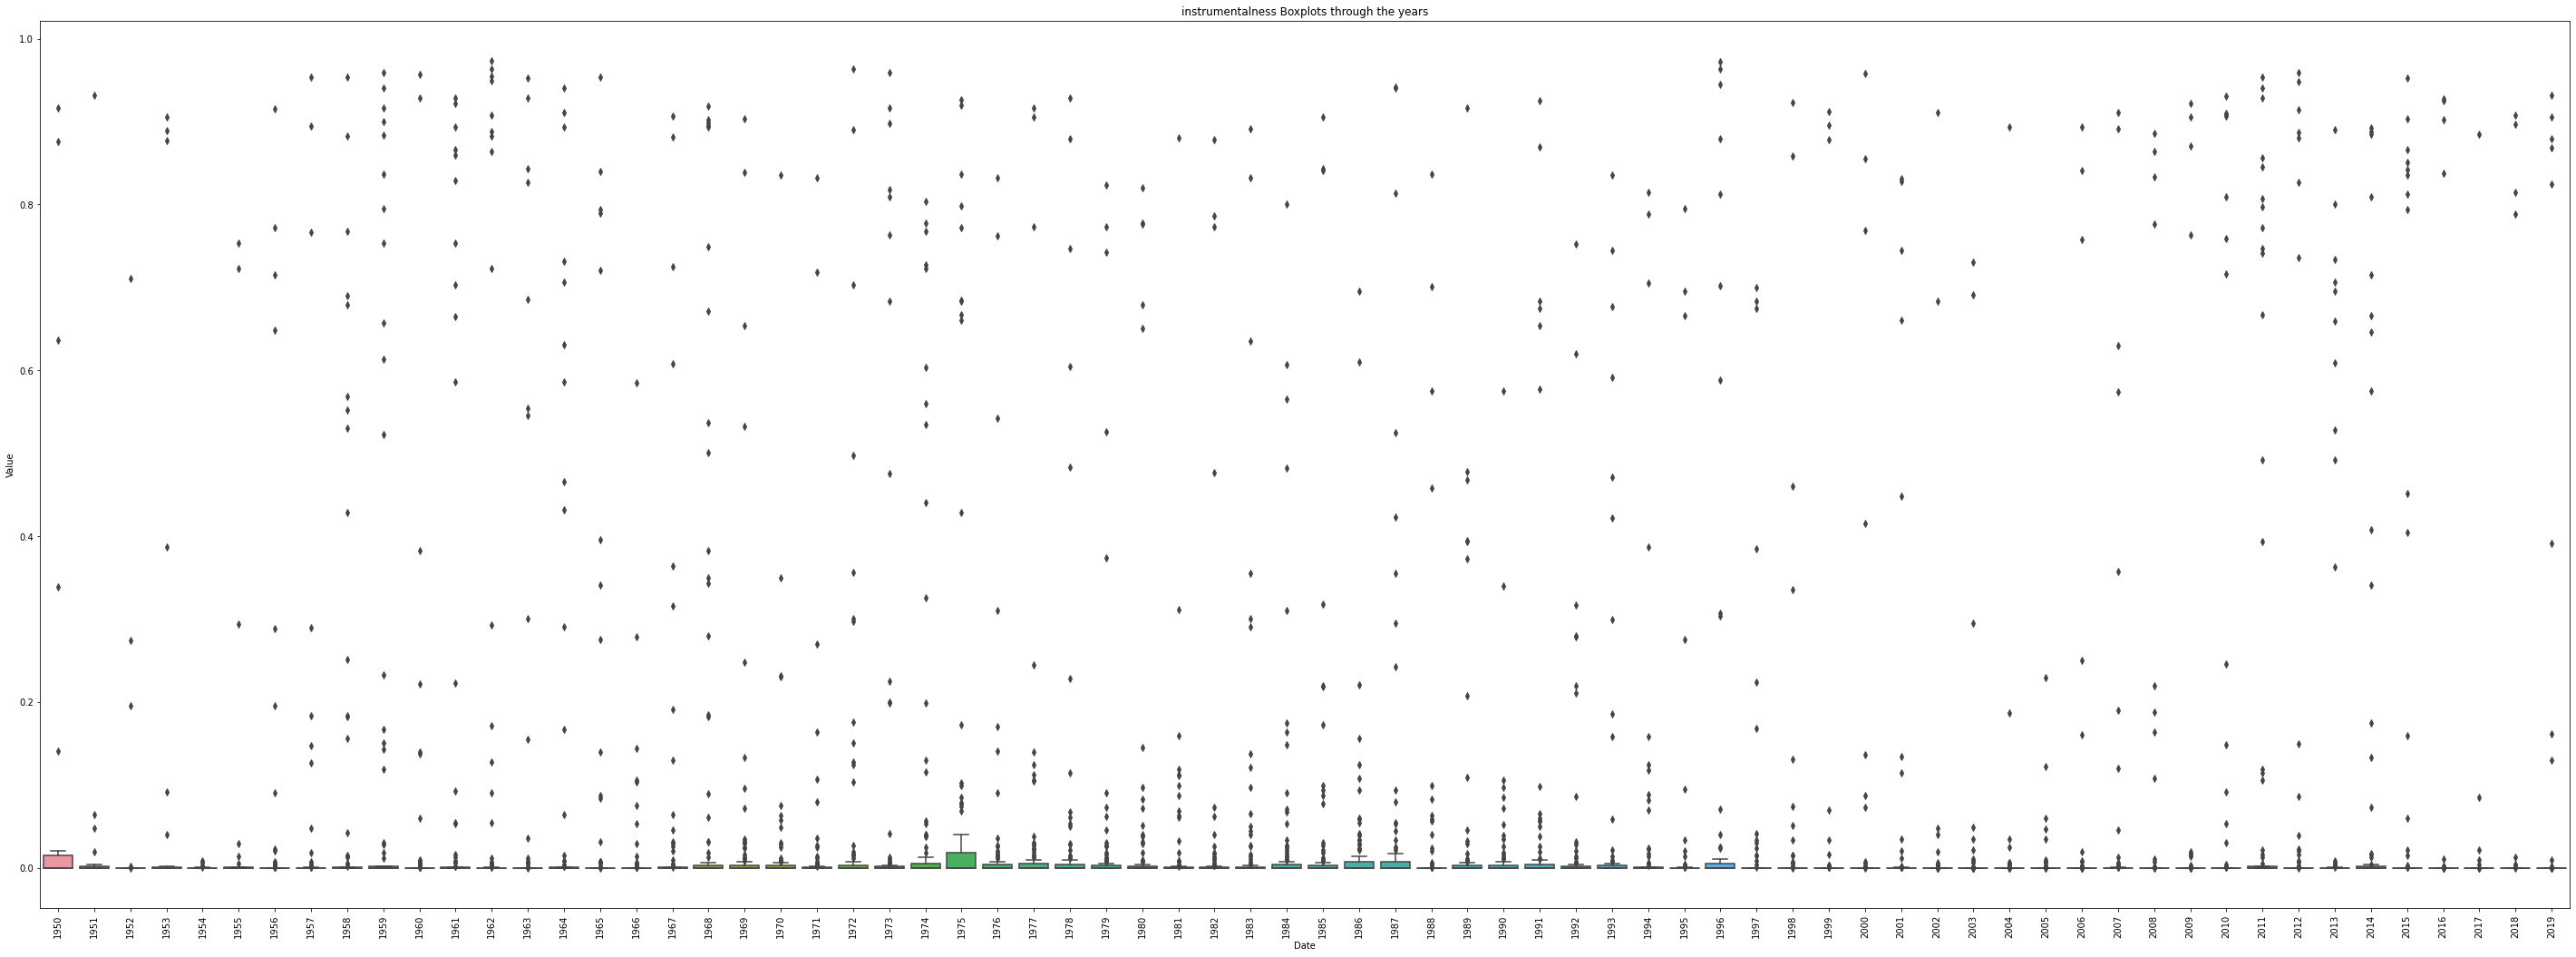

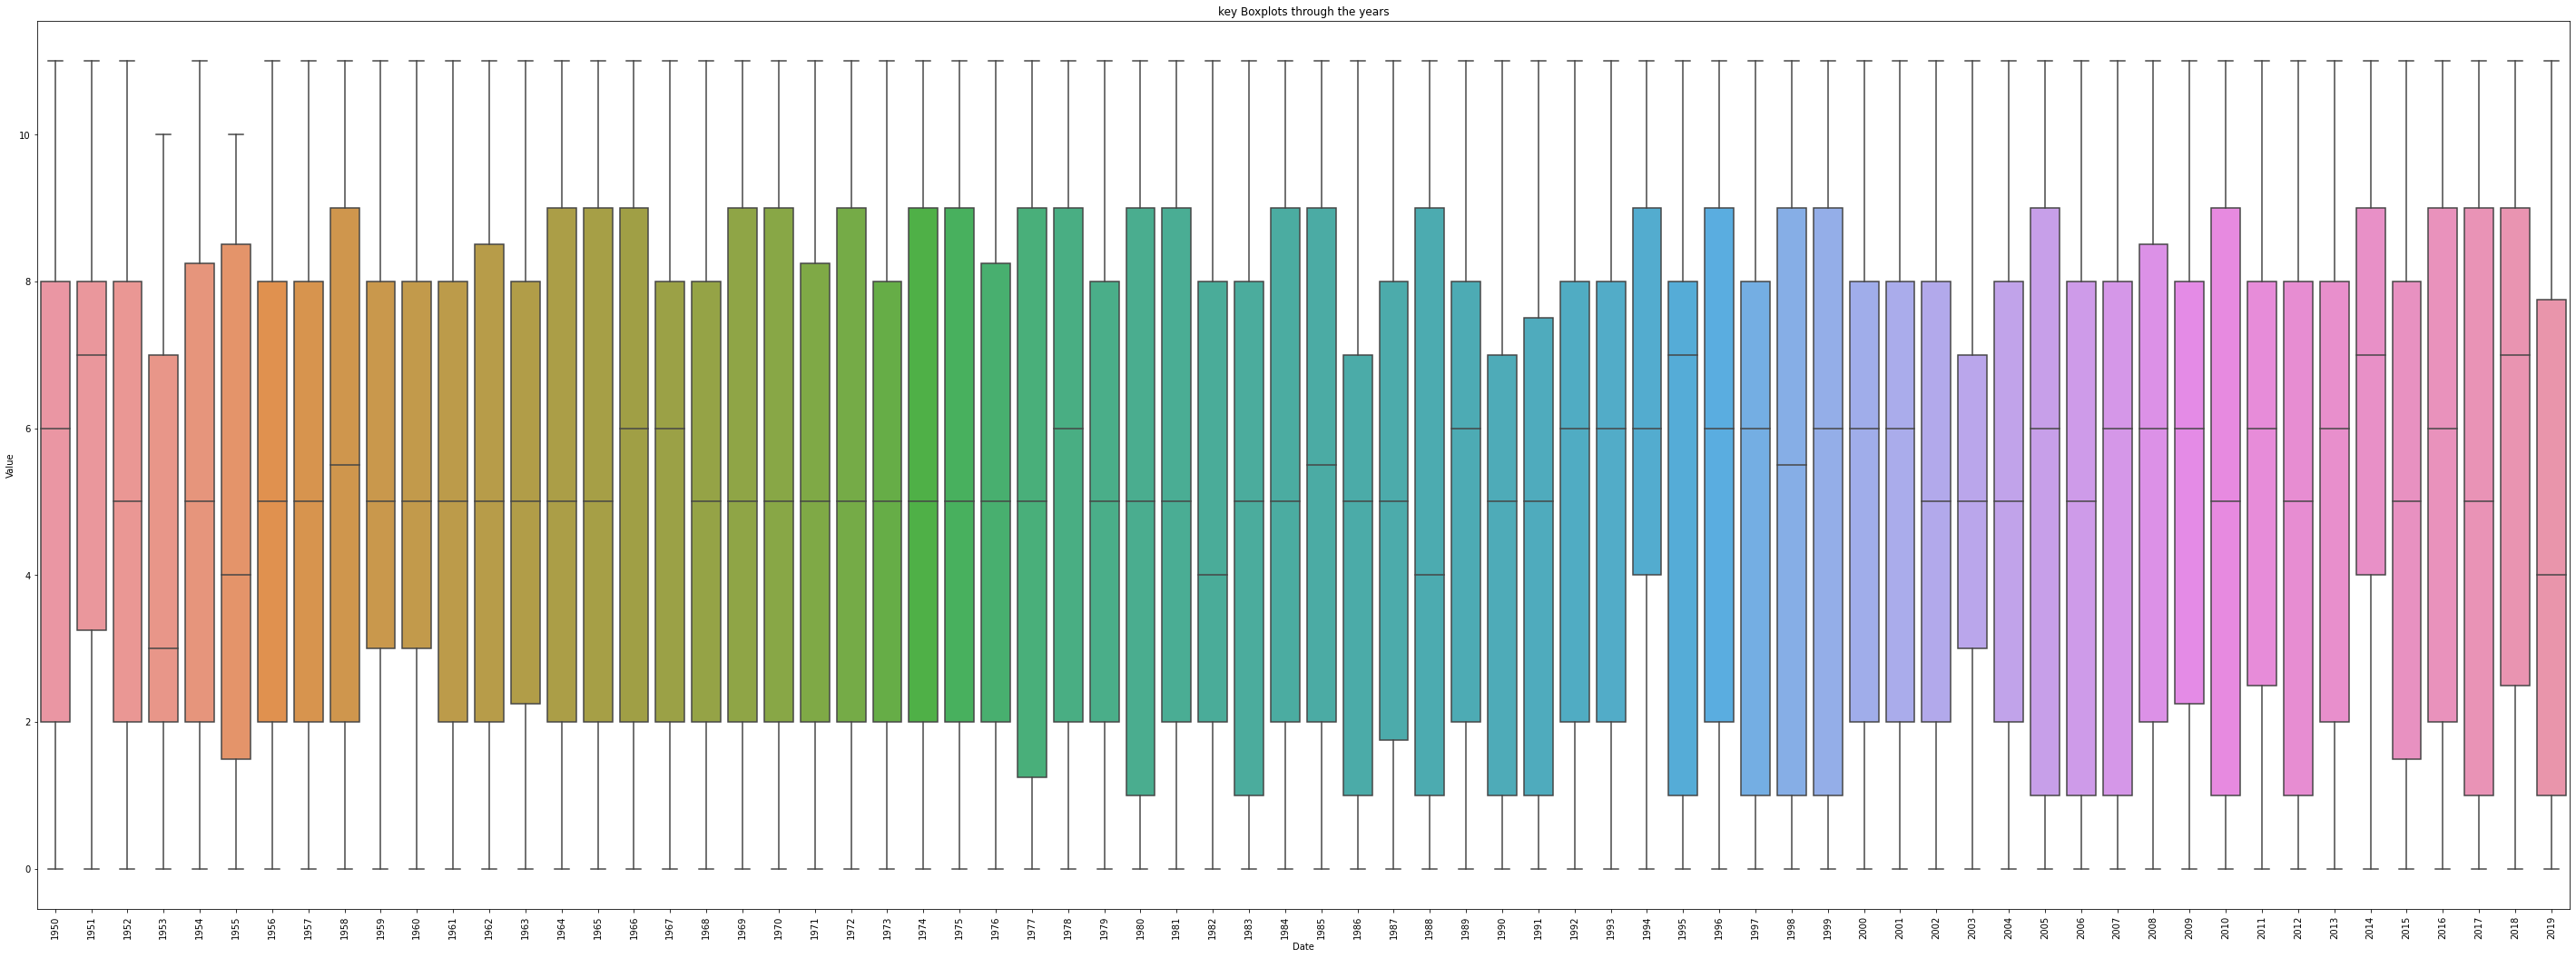

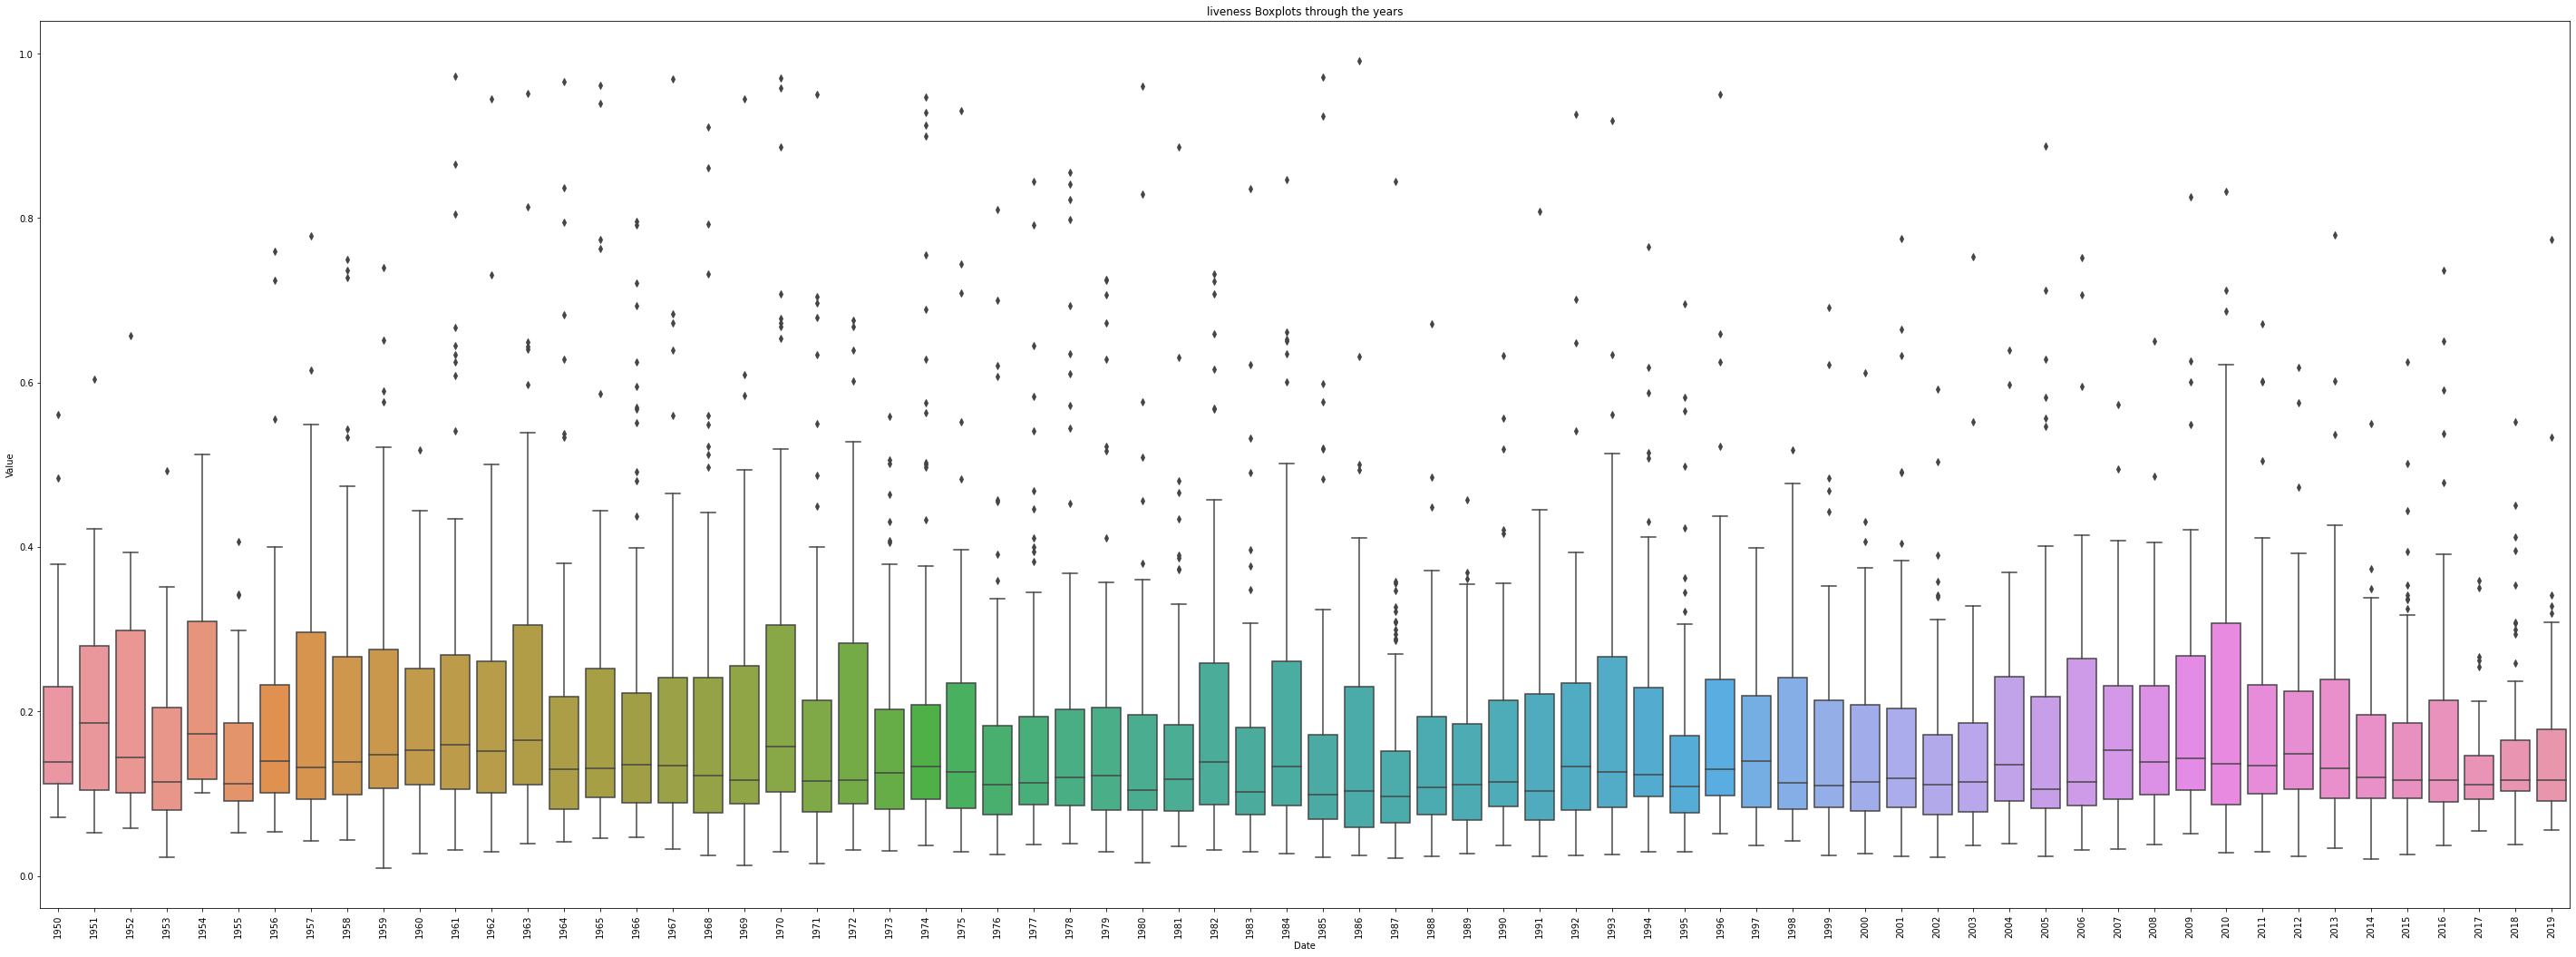

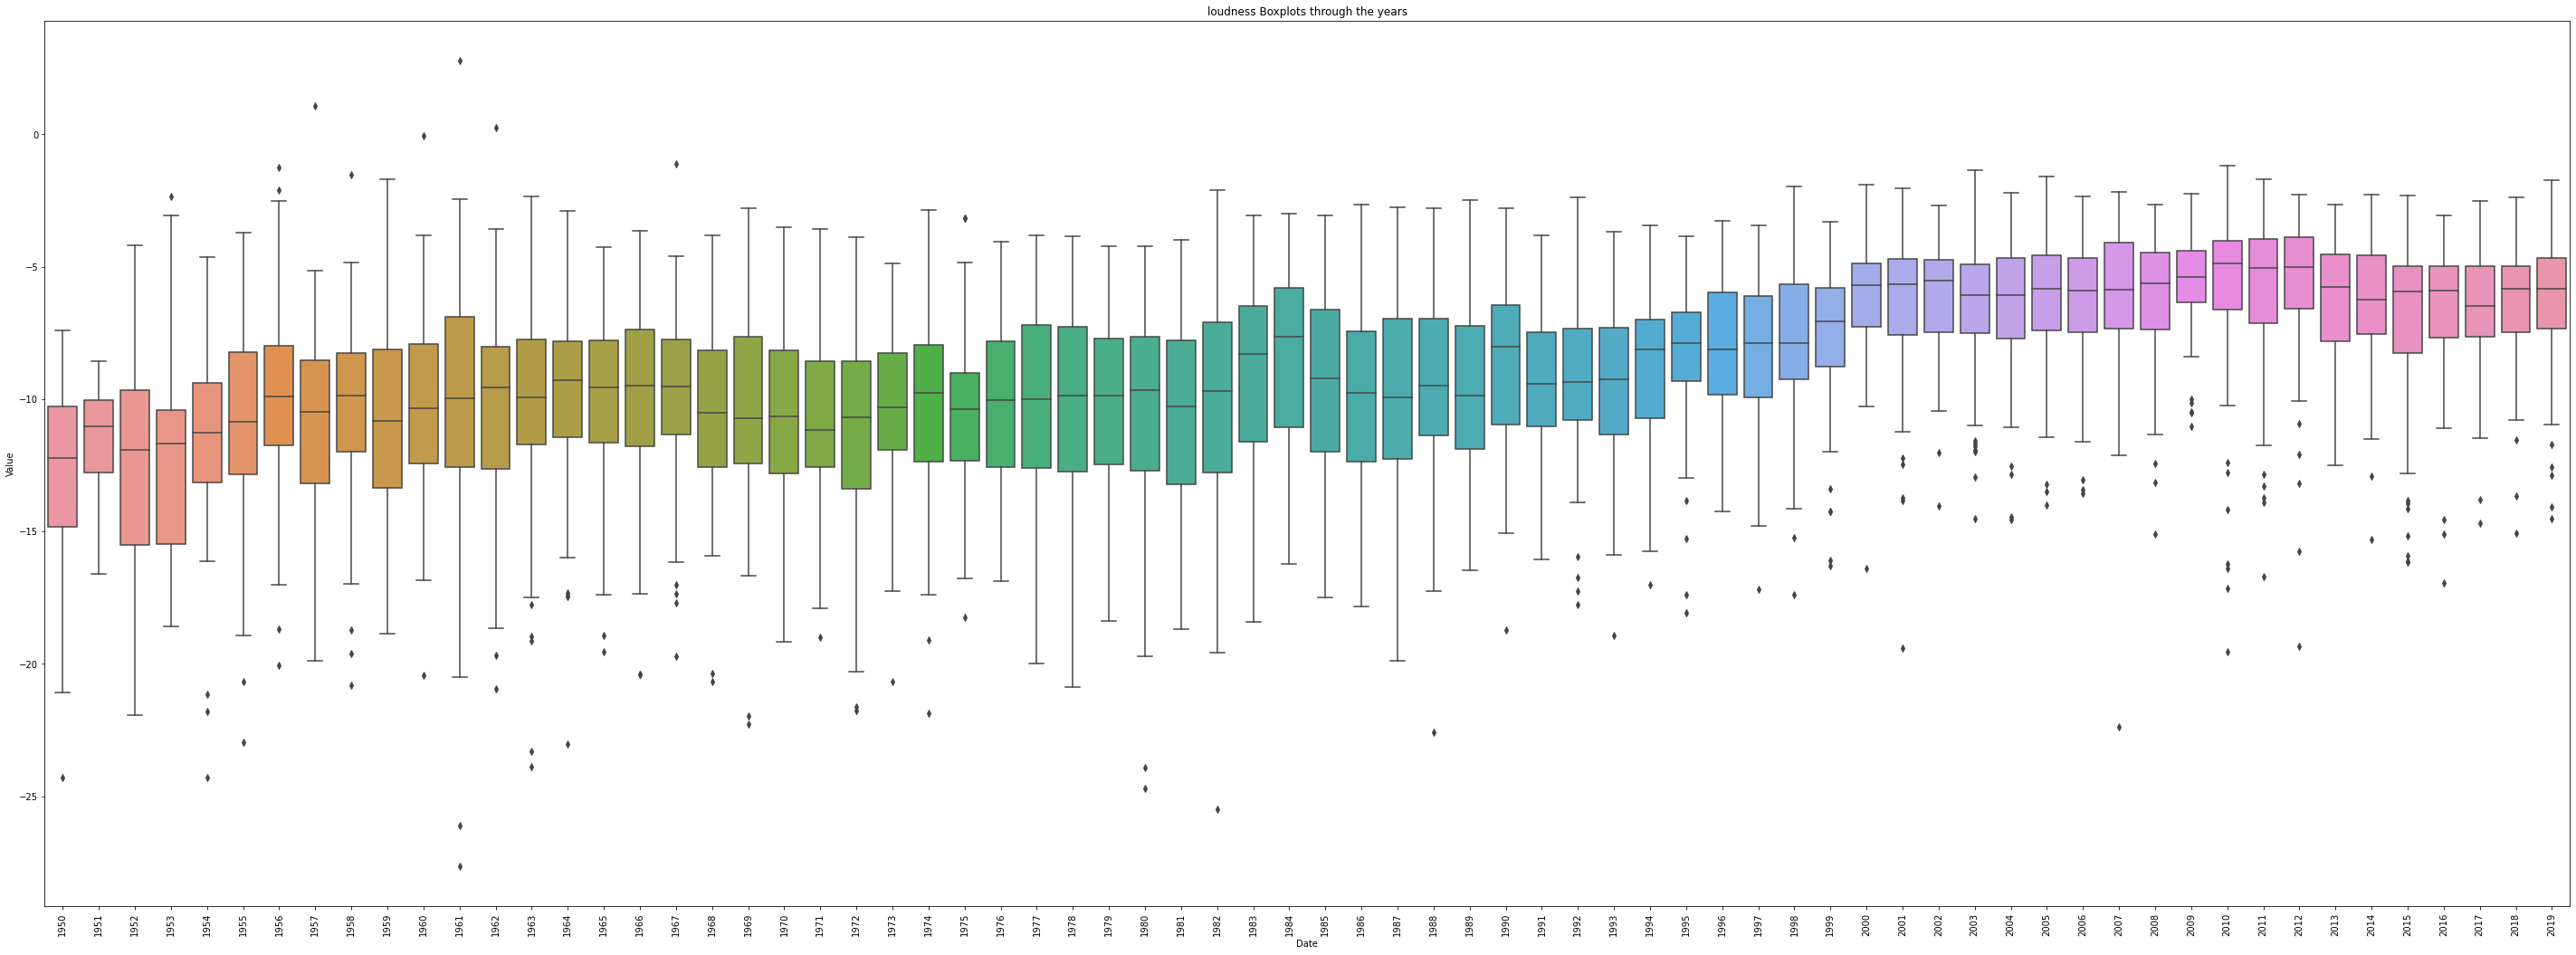

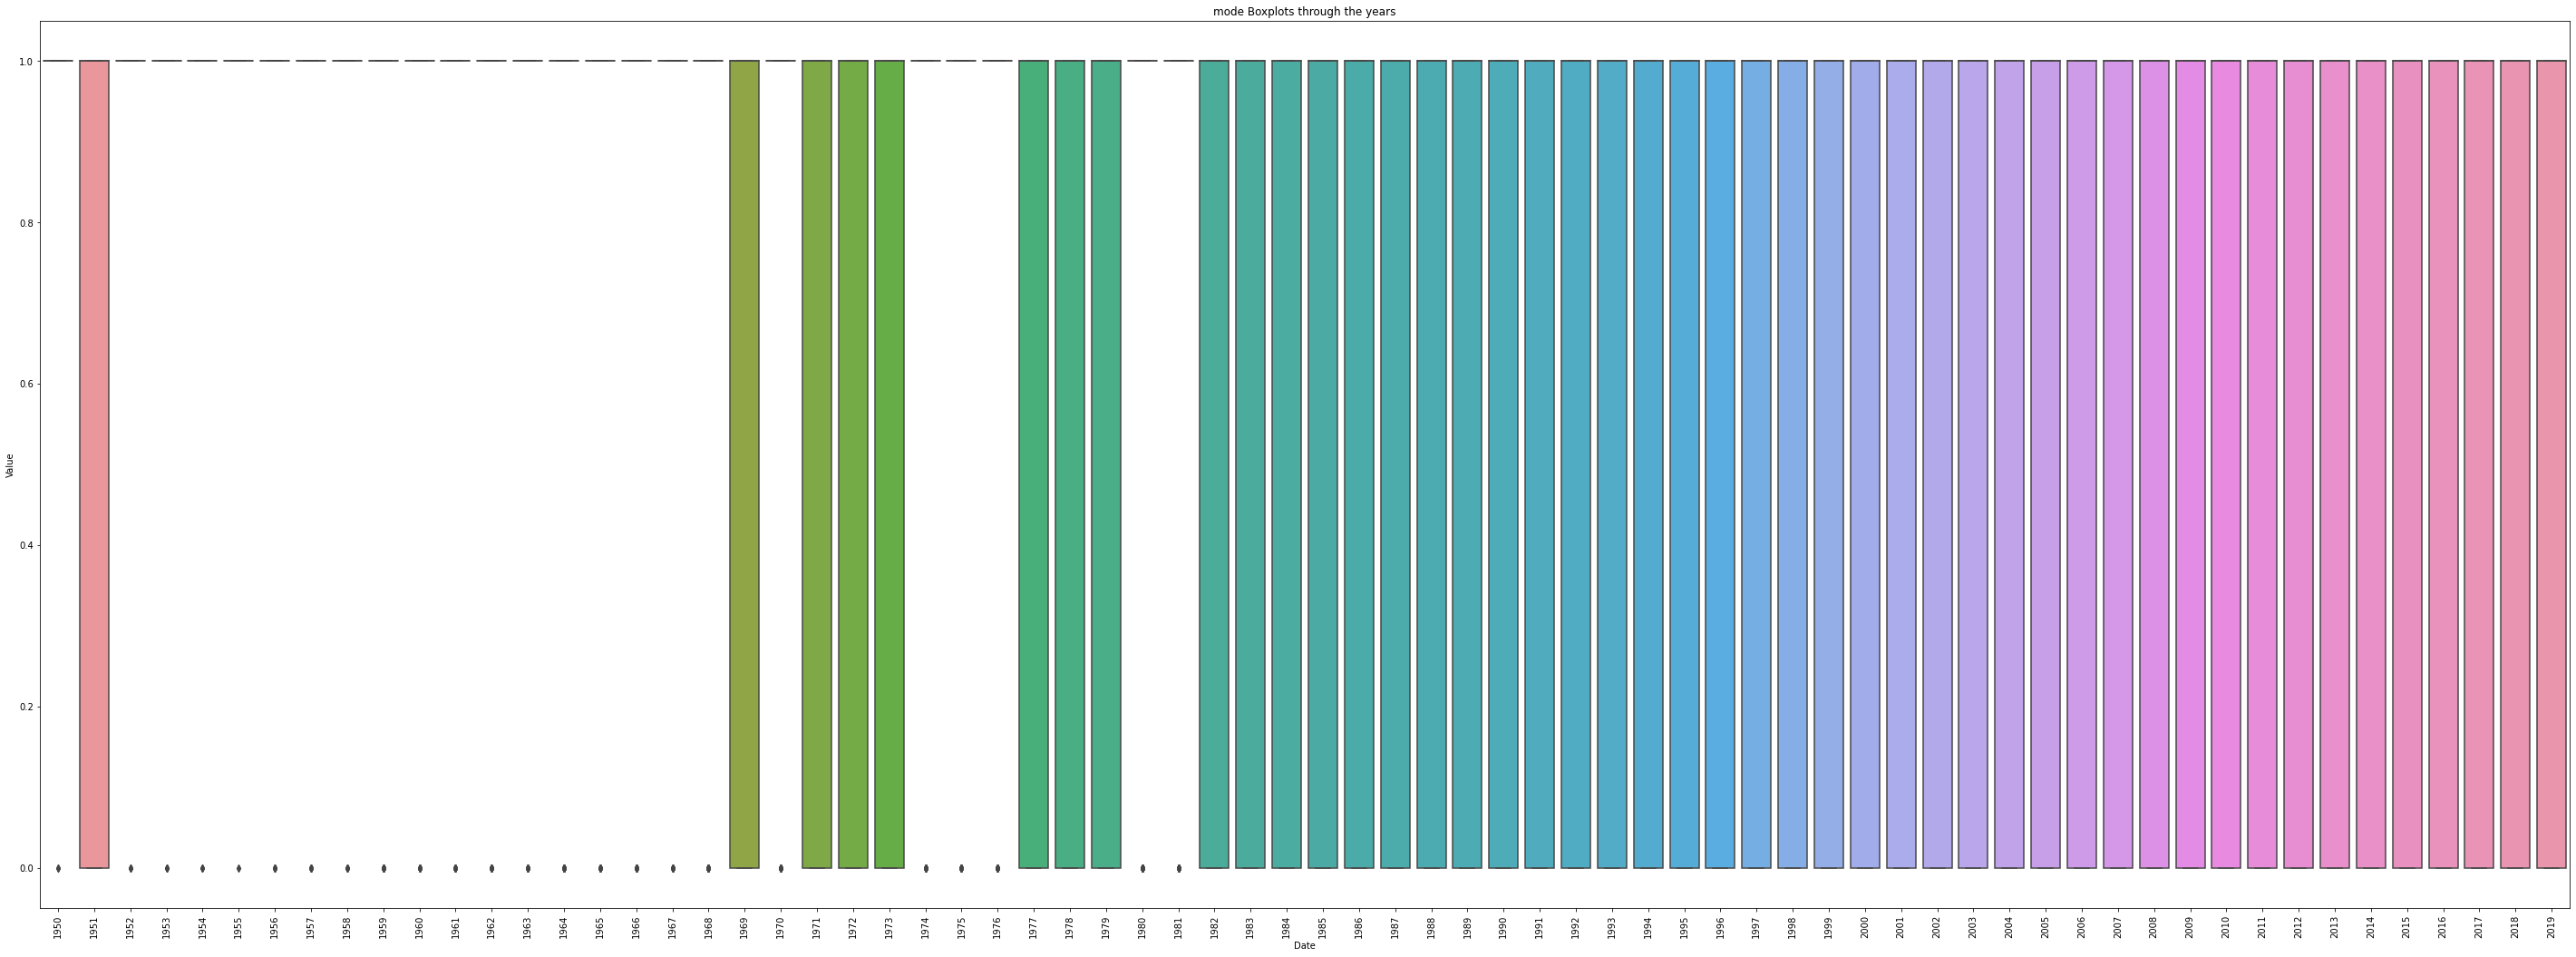

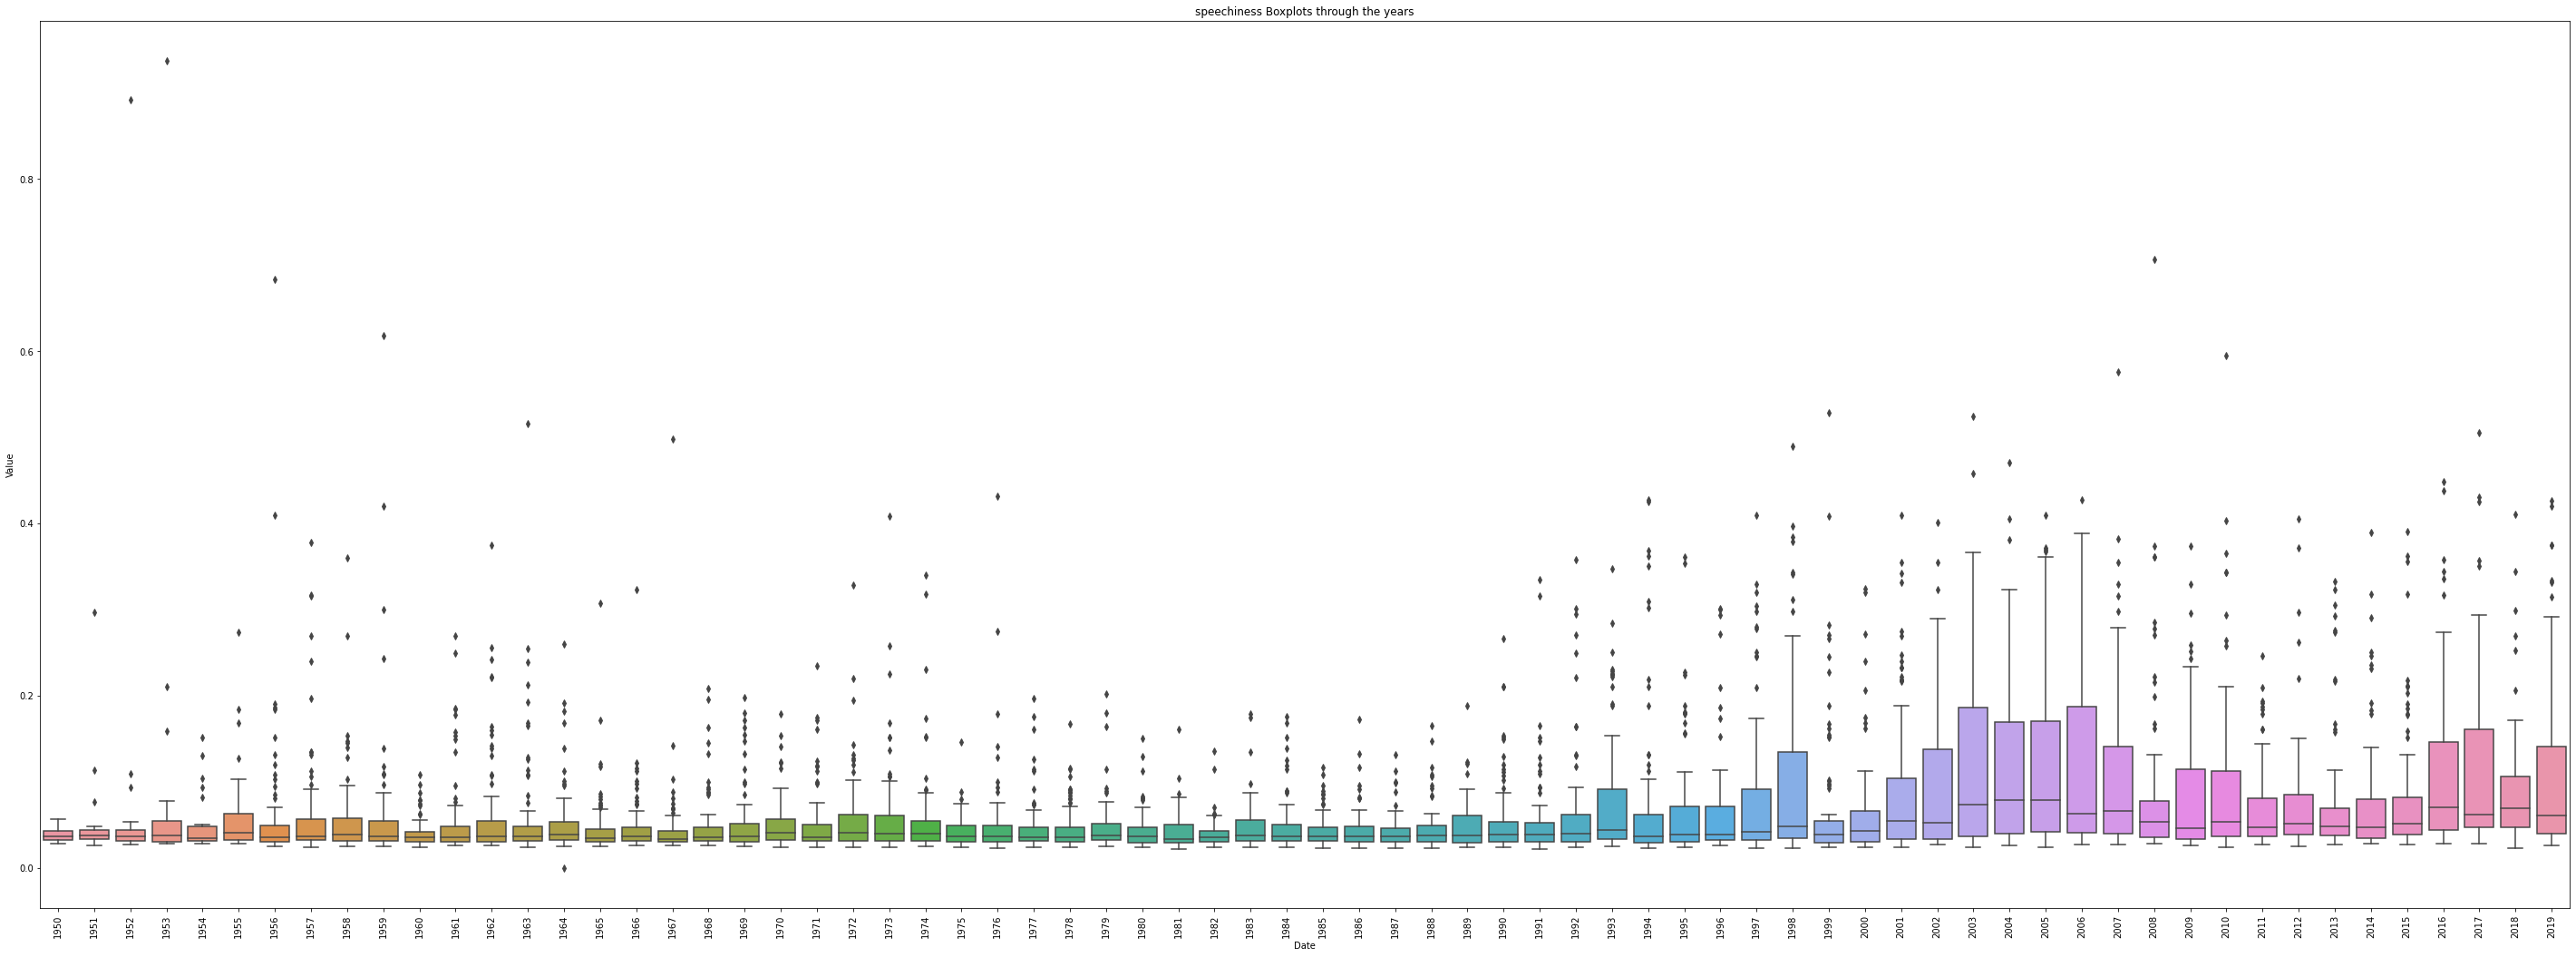

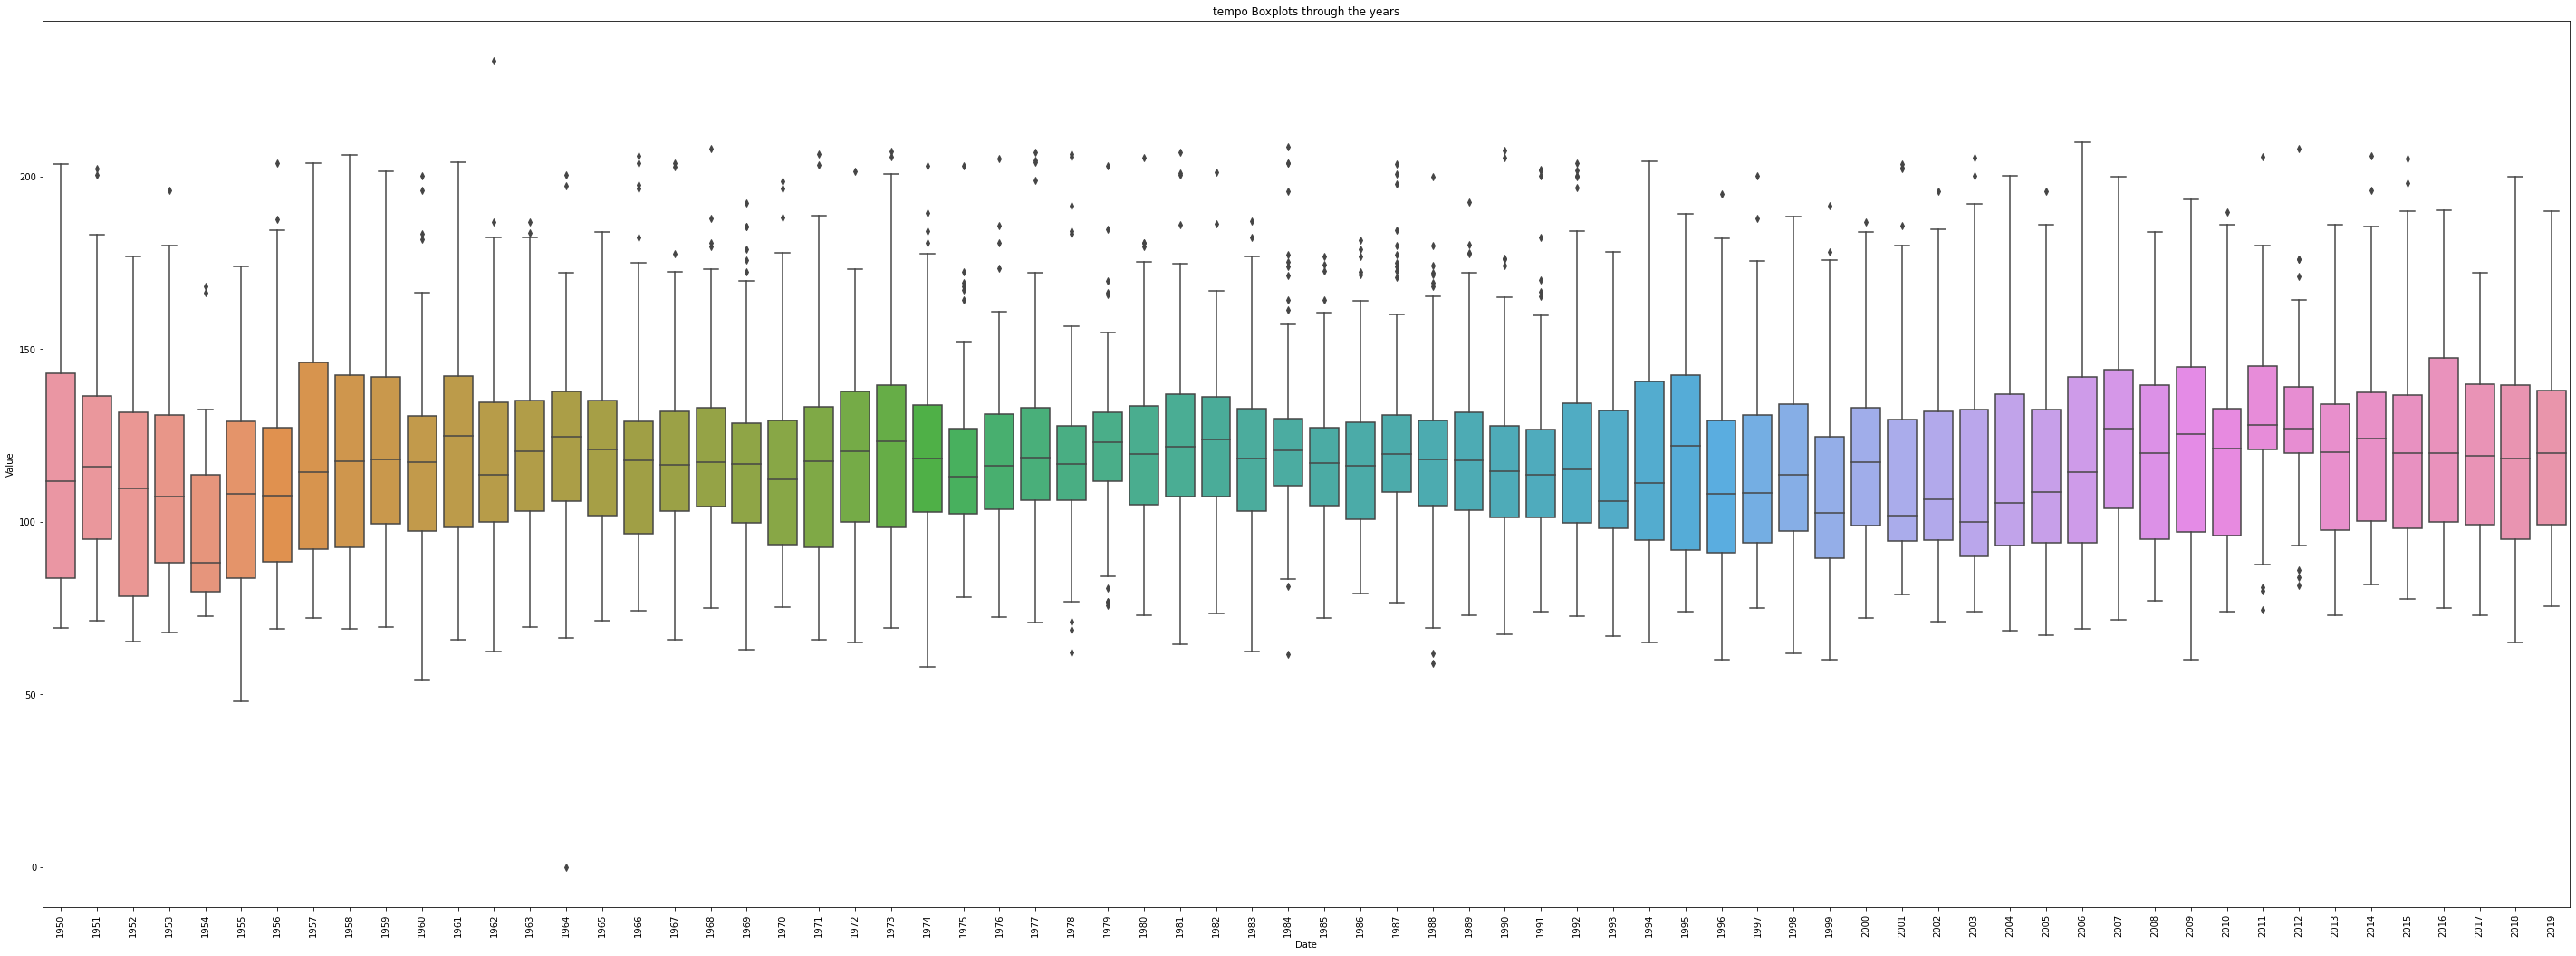

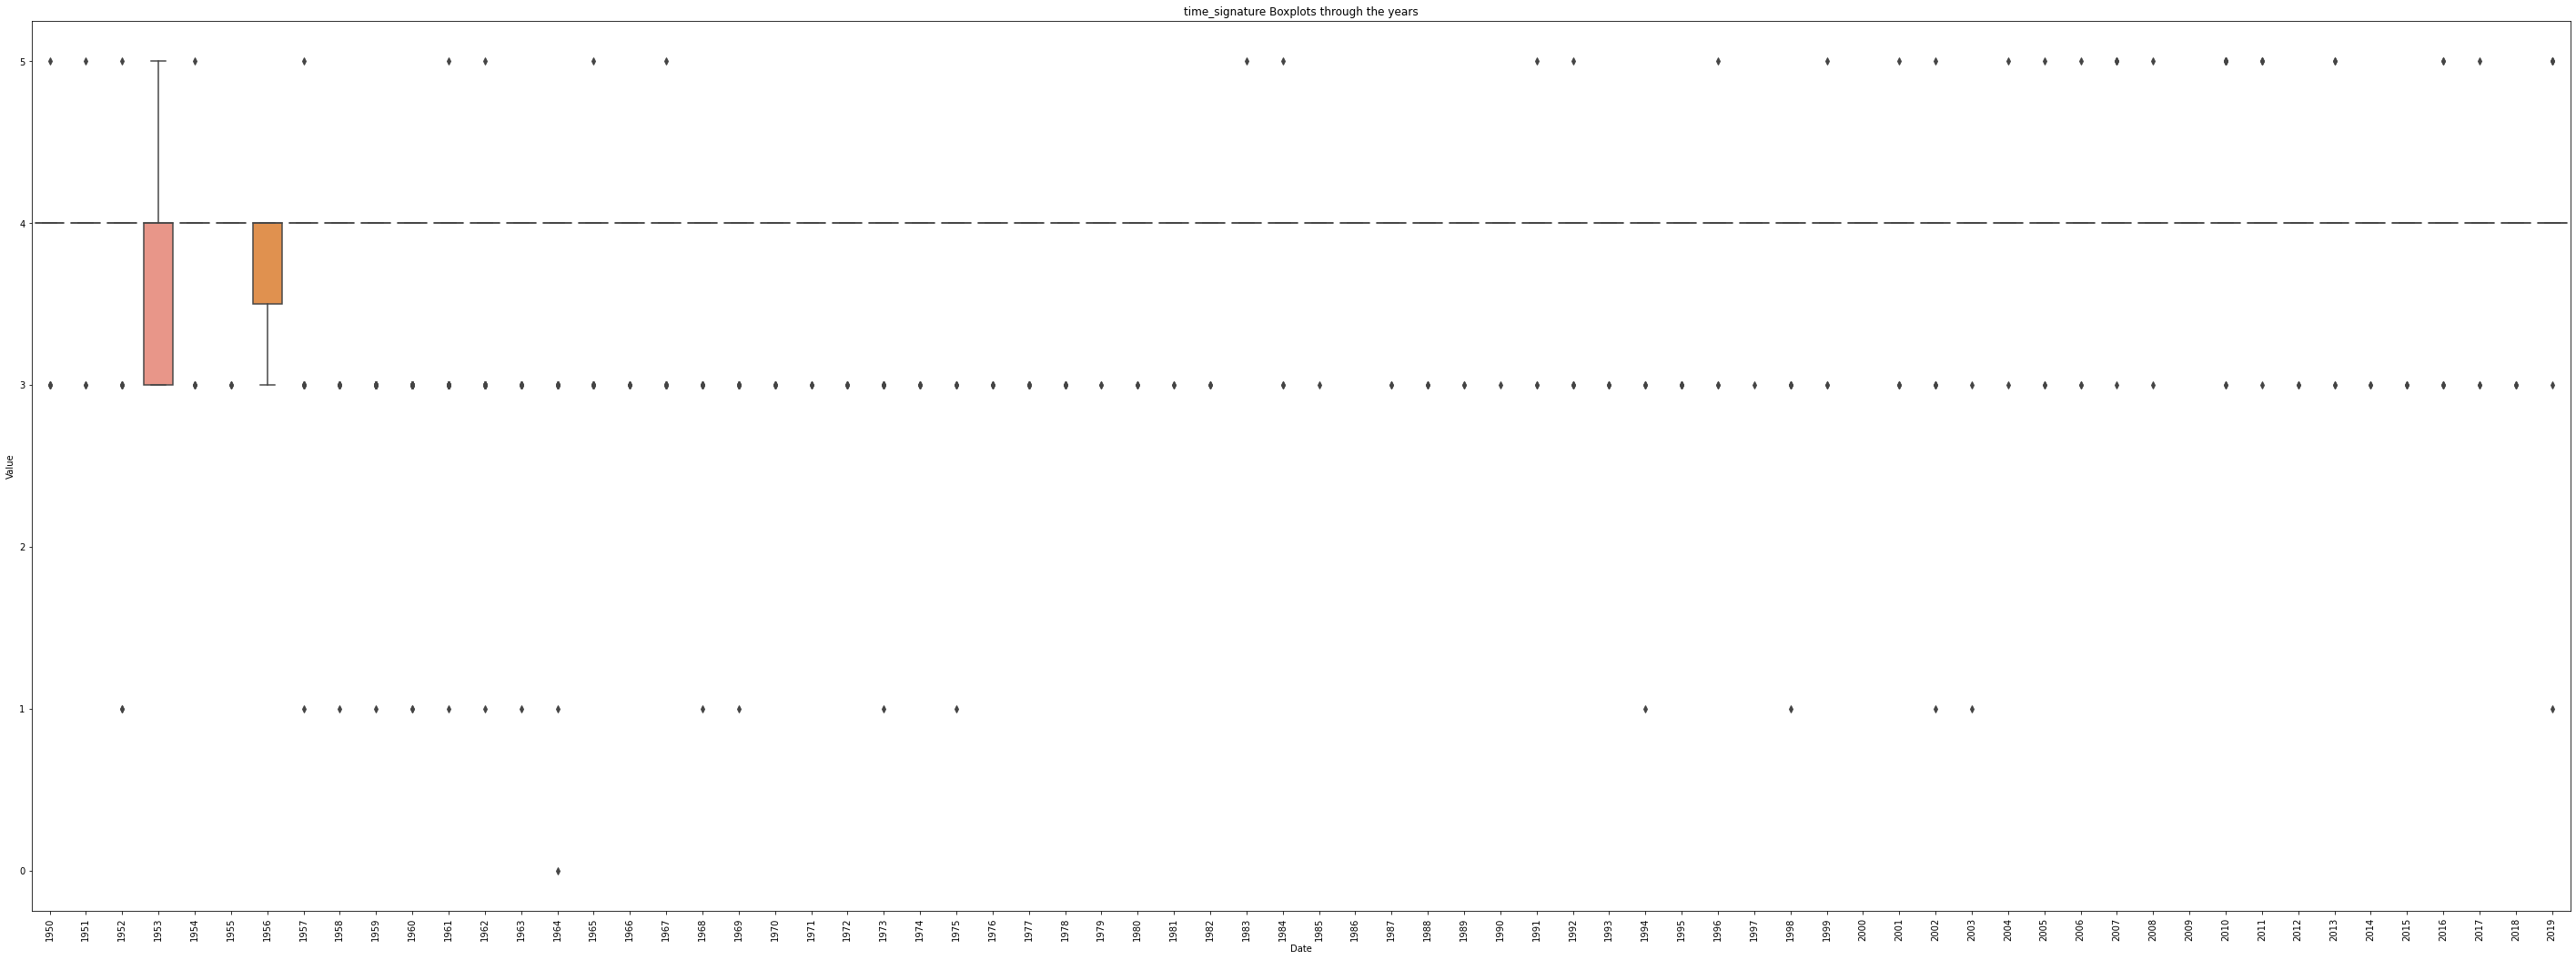

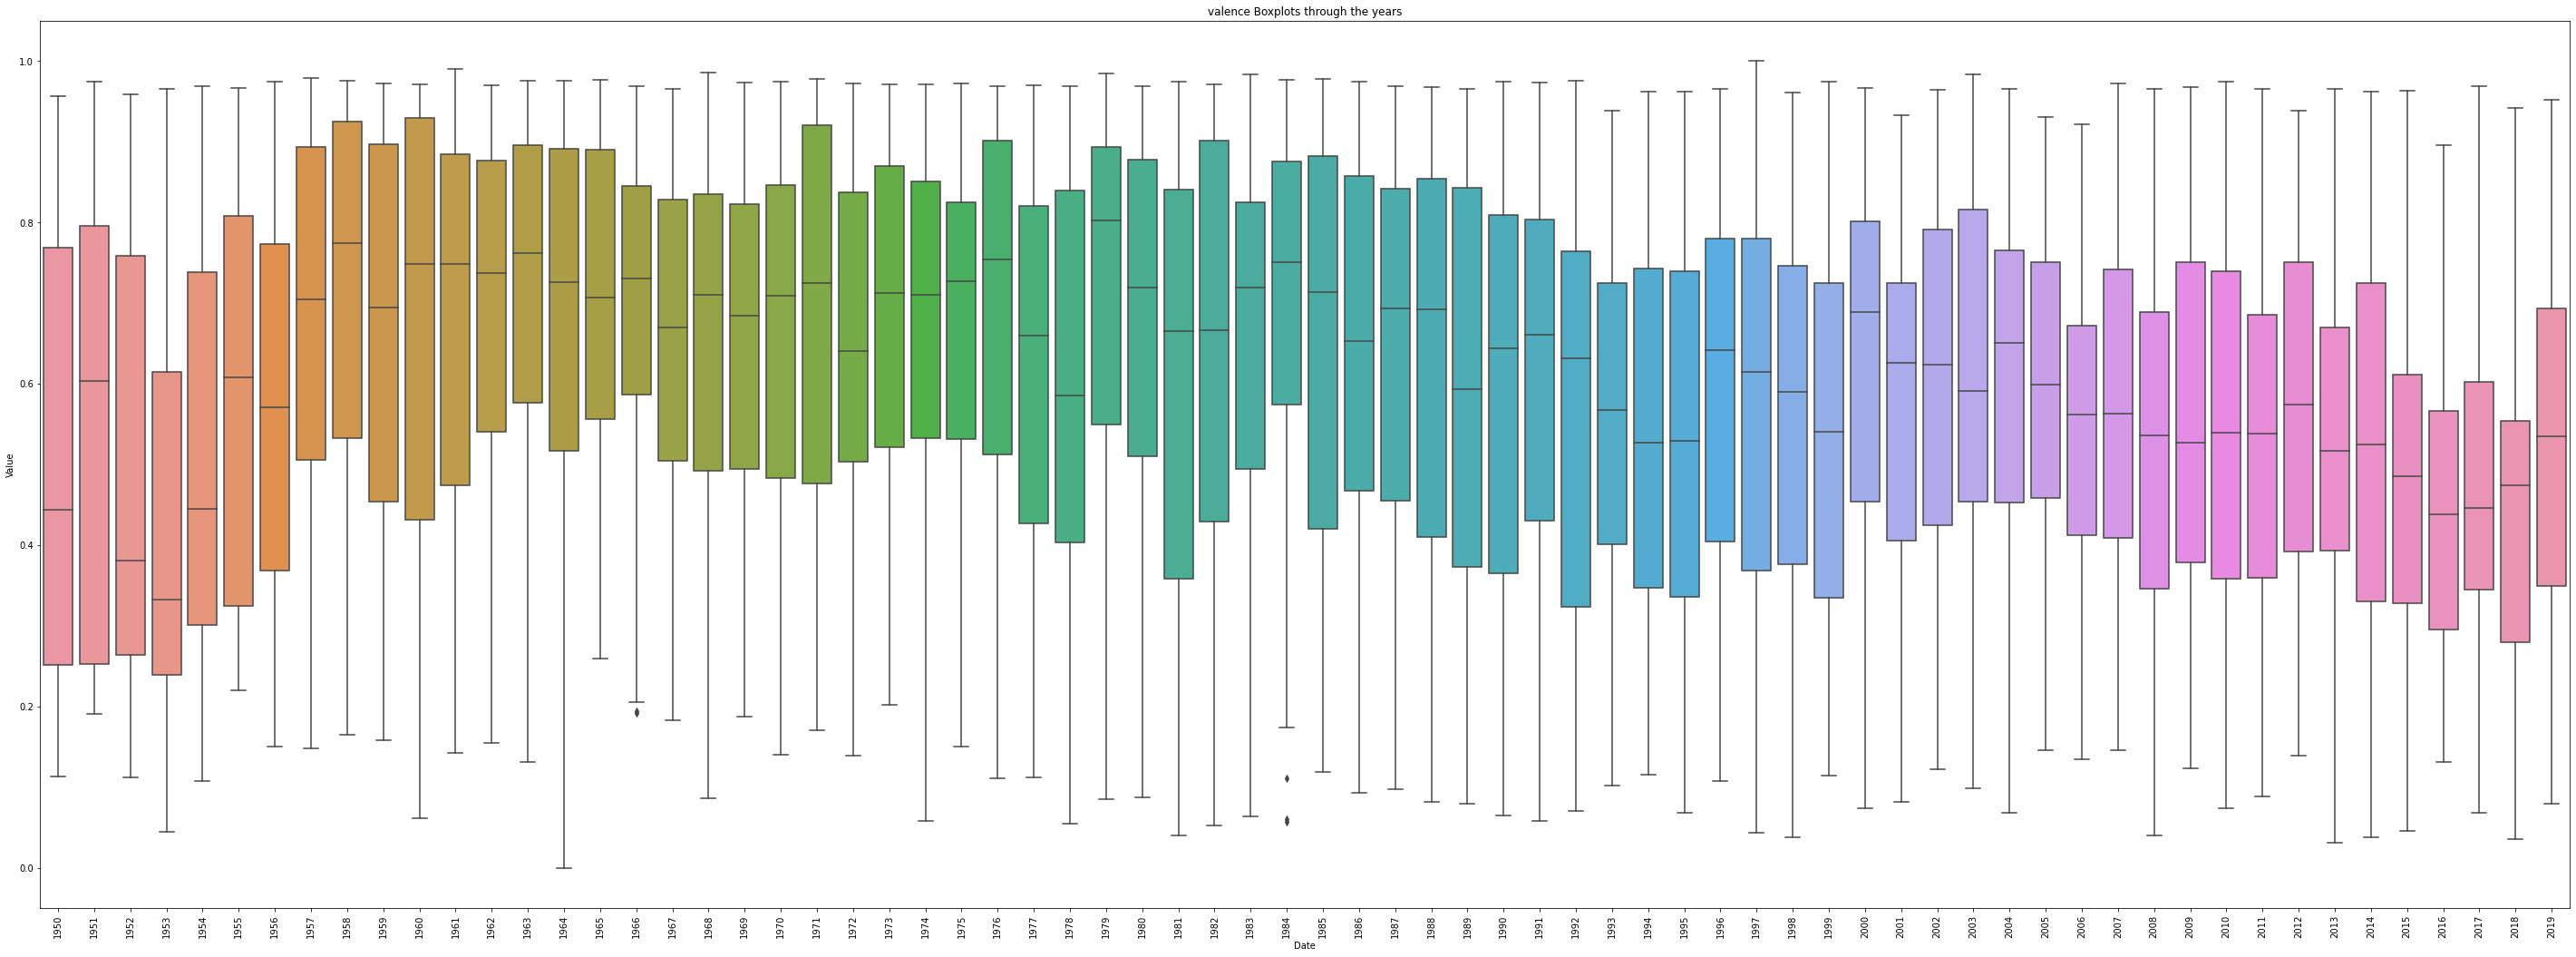

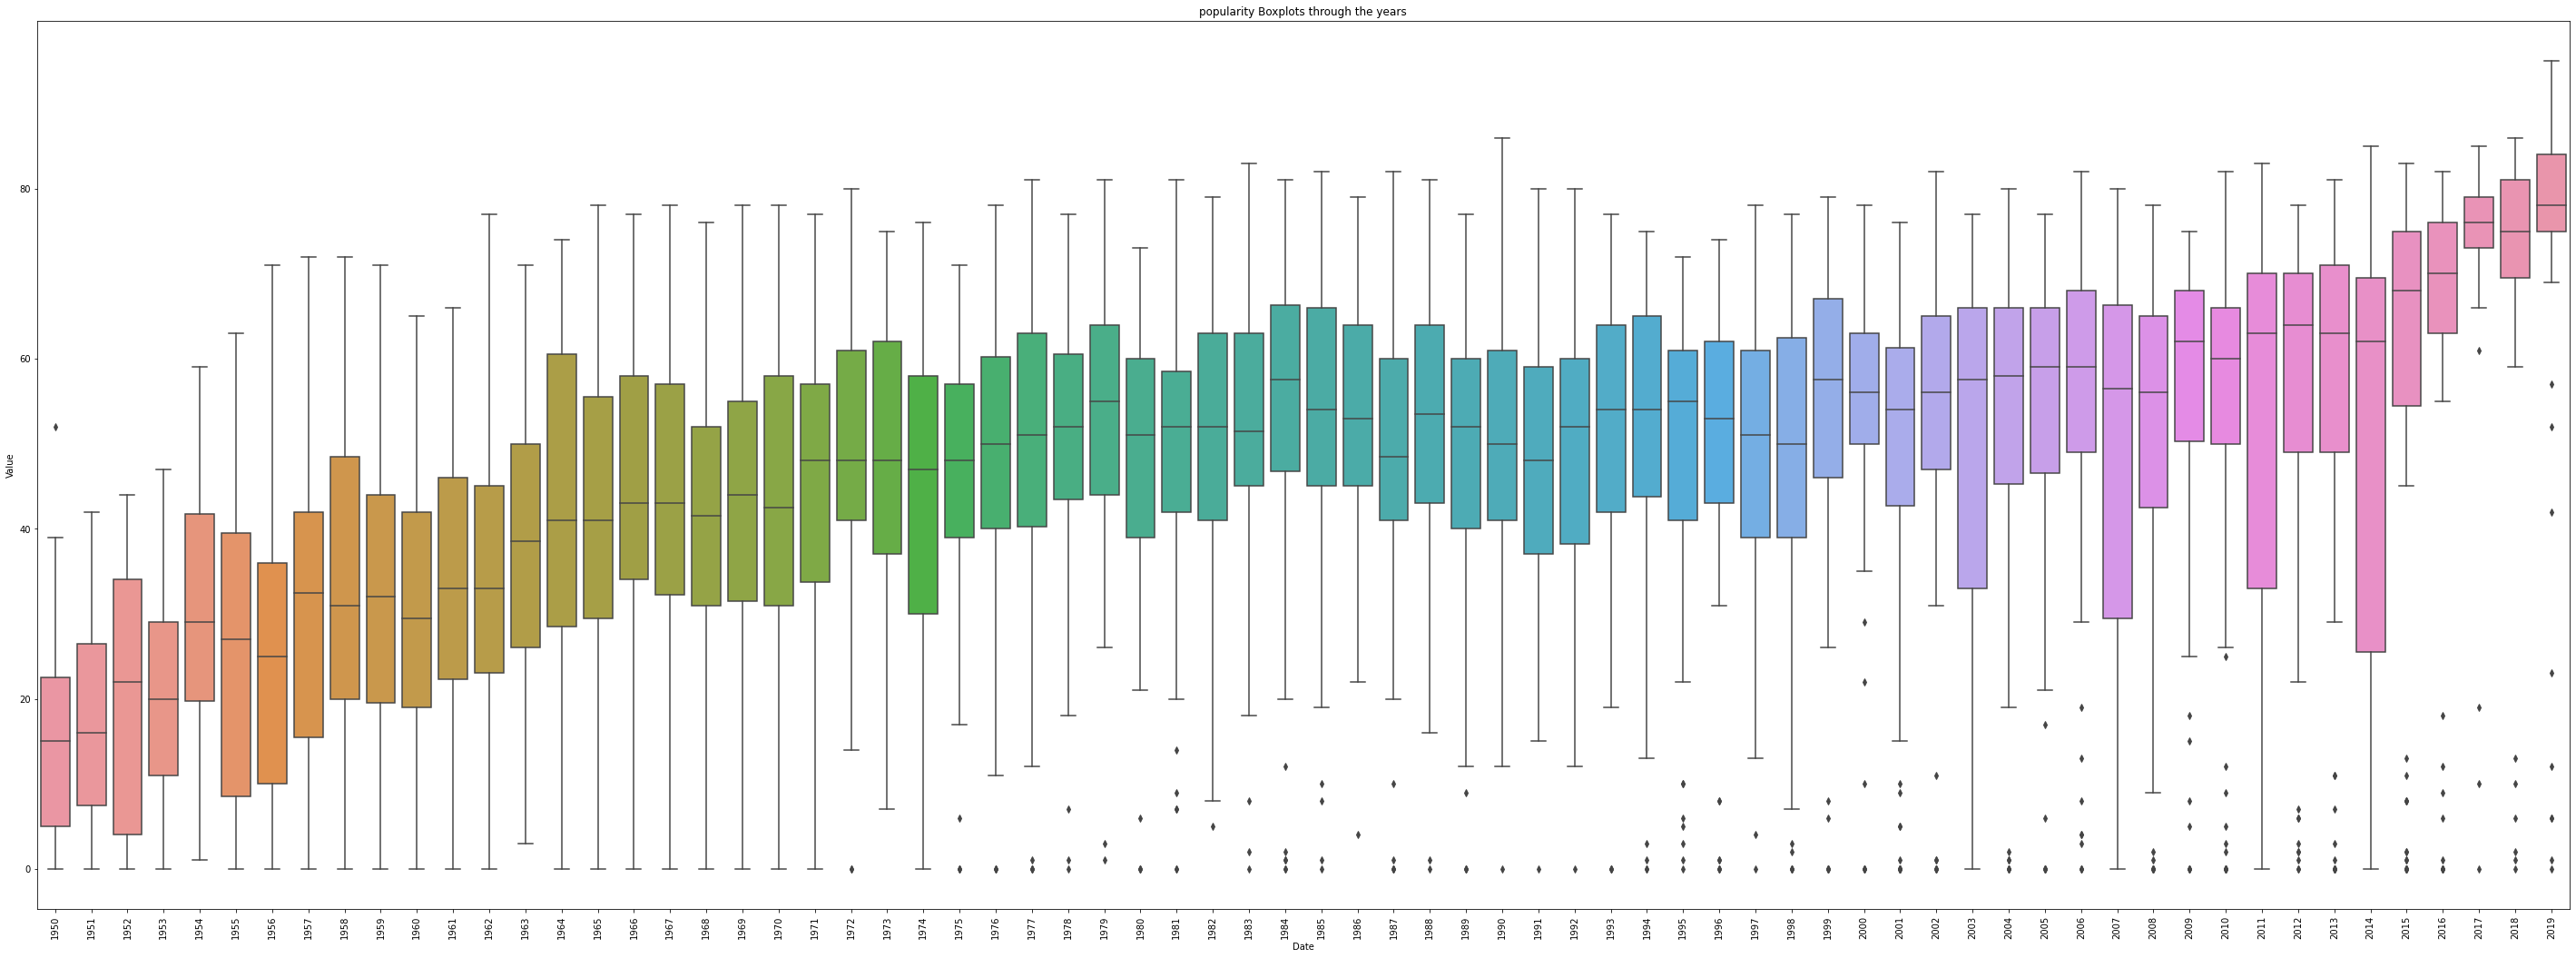

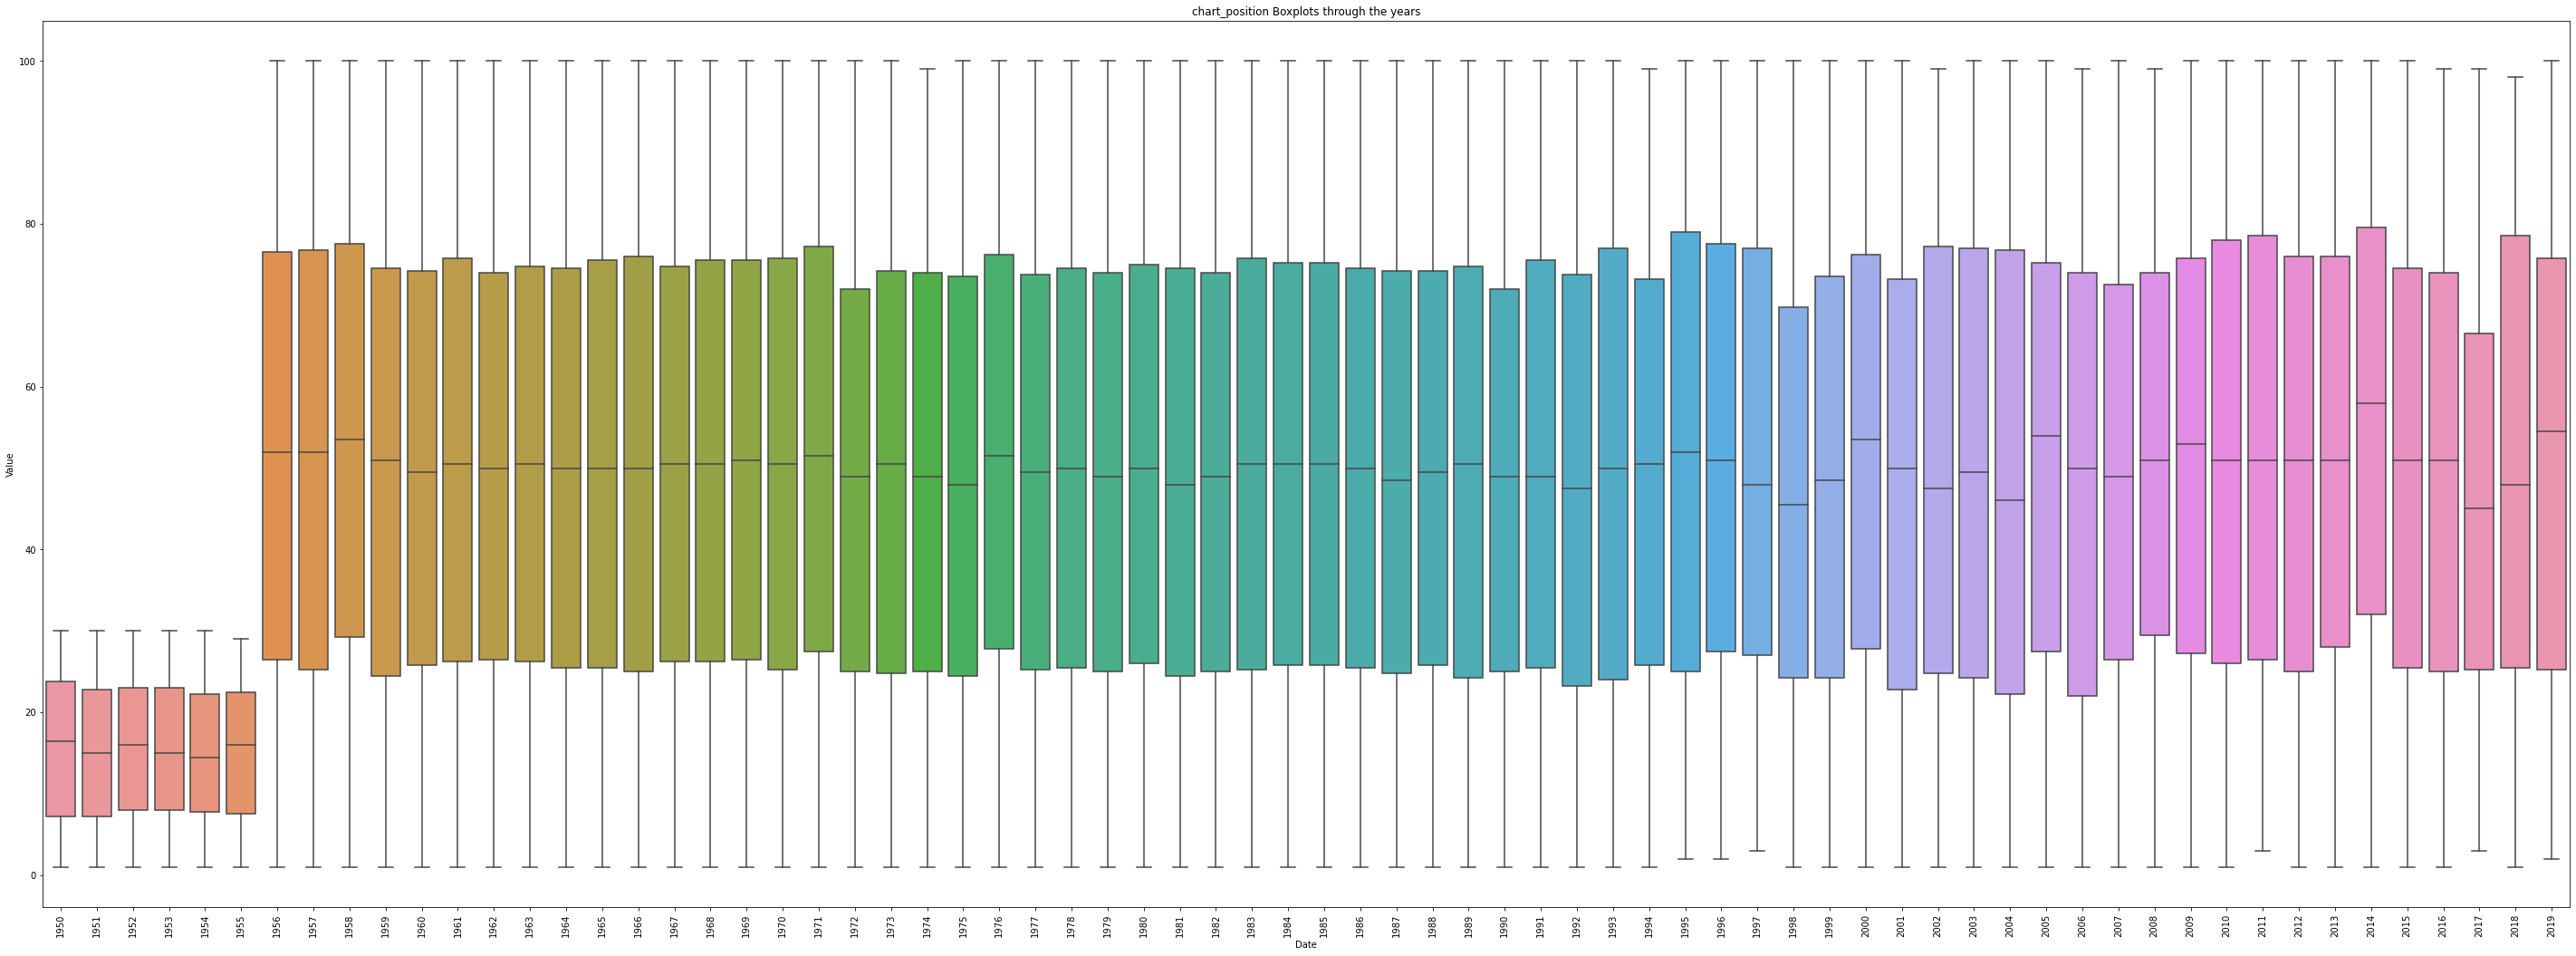

In [0]:


def boxplotting(df, x, y, x_col,y_col,title="", xlabel='Date', ylabel='Value'):
  fig, ax = plt.subplots(figsize=(50,2^16))
  ax = sns.boxplot(data = df, x=x,y=y)
  for item in ax.get_xticklabels():
      item.set_rotation(90)
  plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
  #plt.savefig('/content/drive/My Drive/mldm_cw/eda/boxplot_no_outlier/'+title+'.png')
  plt.show()
cols = data.columns.tolist()
for x in cols[5:]:
  boxplotting(data,x=data['year'],y=data[x],x_col='year',y_col=x,title= x+' Boxplots through the years')


ADF and KPSS, used to determine whether there is unit root present in the time series. So we can determine whether the time series is stationary or non-stationary.

Produce p-level so we deduce whether we reject the null hypothesis  which is there is a unit root present, if there is one the series is non-stationary.


3. Types of Stationarity
Let us understand the different types of stationarities and how to interpret the results of the above tests.

Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.

Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.

Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.
It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [0]:

def stationary_tests(df,title ):
    # ADF Test
  print(title.upper()+'\n')
  result = adfuller(df.values, autolag='AIC')
  print(f'ADF Statistic: {result[0]}'+'\n')
  p_value = result[1]
  print(f'p-value: {result[1]}'+'\n')
  for key, value in result[4].items():
      print('Critial Values:\n')
      print(f'   {key}, {value}\n')
  print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary\n')


  #f.write('\n')
  #f.write('\n')

  # KPSS Test
  result = kpss(df.values)
  print('\nKPSS Statistic: %f\n' % result[0])
  p_value = result[1]
  print('p-value: %f\n' % result[1])
  for key, value in result[3].items():
      print('Critial Values:\n')
      print(f'   {key}, {value}\n')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n')

  

  


Cleaning.

Although most variables have been been plotted, only a few will actually be forcasted, as these have deemed an important essential characterstic of a song.

Hence cleaning will only be applied to those series. Some are already stationary hence will need to be transformed.

The features essential which we will be carrying on forward with:
Acousticness, Danceability,Energy,Liveness,Loudness,and Valence.

According to the ADF and KPSS the following features were not completely stationary. Hence differencing applied to ensure a constant mean and varience and remove trend and seasonality from the series.

In [0]:
#normalise loudness as it is not in a range between 0 and 1 unilike the rest.
def normal(x):
  normalised = (x-min(data['loudness']))/(max(data['loudness'])-min(data['loudness']))
  return normalised

data['loudness'] = data['loudness'].apply(normal)

In [0]:
data['loudness'].head()

release_date
1950-01-01 00:00:00    0.507712
1950-01-01 01:00:00    0.665527
1950-01-01 02:00:00    0.409747
1950-01-01 03:00:00    0.642244
1950-01-01 04:00:00    0.470190
Name: loudness, dtype: float64

In [0]:
cols = ['acousticness', 'danceability','energy','liveness','loudness', 'valence']
data2=data
for x in cols:
  #data[x]= data[x].replace(to_replace=0, method='ffill')
  df_ma = data[x].rolling(12, center=True, closed='both').mean()
  data2[x+'_ma']=df_ma
  print(len(df_ma))
  df_ma.dropna(inplace=True)
  print(len(df_ma))
  stationary_tests(df_ma,title=x+'_ma')



5759
5748
ACOUSTICNESS_MA

ADF Statistic: -2.8082323528832482

p-value: 0.05710742316886485

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is not stationary


KPSS Statistic: 13.555326

p-value: 0.010000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is not stationary

5759
5748
DANCEABILITY_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF Statistic: -5.11340882308233

p-value: 1.3174268891639738e-05

Critial Values:

   1%, -3.431493747734818

Critial Values:

   5%, -2.86204542682405

Critial Values:

   10%, -2.5670390369027825

Result: The series is stationary


KPSS Statistic: 12.723821

p-value: 0.010000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is not stationary

5759
5748
ENERGY_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF Statistic: -5.142083221643378

p-value: 1.1529779100803052e-05

Critial Values:

   1%, -3.4314945484779873

Critial Values:

   5%, -2.8620457806076405

Critial Values:

   10%, -2.5670392252322554

Result: The series is stationary


KPSS Statistic: 10.444747

p-value: 0.010000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is not stationary

5759
5748
LIVENESS_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF Statistic: -10.345710997886156

p-value: 2.614422929944551e-18

Critial Values:

   1%, -3.431495149771543

Critial Values:

   5%, -2.8620460462705286

Critial Values:

   10%, -2.567039366652482

Result: The series is stationary


KPSS Statistic: 2.920688

p-value: 0.010000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is not stationary

5759
5748
LOUDNESS_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF Statistic: -3.5838765140679096

p-value: 0.006076862005142435

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is stationary


KPSS Statistic: 13.143092

p-value: 0.010000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is not stationary

5759
5748
VALENCE_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF Statistic: -6.1714642180162

p-value: 6.789154515531737e-08

Critial Values:

   1%, -3.431493347783246

Critial Values:

   5%, -2.862045250117789

Critial Values:

   10%, -2.567038942836817

Result: The series is stationary


KPSS Statistic: 7.416446

p-value: 0.010000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is not stationary



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



In [0]:
cols = ['acousticness', 'danceability','energy','liveness','loudness', 'valence']
for x in cols:
  diff = data[x+'_ma'].diff()
  data2[x+'_ma_diff']=diff
  print(len(diff))
  diff.dropna(inplace=True)
  stationary_tests(diff,title =x+'_ma')
  print(len(diff))

#data2.to_csv('/content/drive/My Drive/mldm_cw/datasets/billboard_1950-2019_ultimate_2.0.csv',index=False)

5759
ACOUSTICNESS_MA

ADF Statistic: -25.40385093548787

p-value: 0.0

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is stationary


KPSS Statistic: 0.054204

p-value: 0.100000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is stationary

5747
5759
DANCEABILITY_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF Statistic: -22.103683409762425

p-value: 0.0

Critial Values:

   1%, -3.431493747734818

Critial Values:

   5%, -2.86204542682405

Critial Values:

   10%, -2.5670390369027825

Result: The series is stationary


KPSS Statistic: 0.003905

p-value: 0.100000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is stationary

5747
5759
ENERGY_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF Statistic: -26.646524240695033

p-value: 0.0

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is stationary


KPSS Statistic: 0.024590

p-value: 0.100000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is stationary

5747
5759
LIVENESS_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF Statistic: -26.70775314155117

p-value: 0.0

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is stationary


KPSS Statistic: 0.004014

p-value: 0.100000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is stationary

5747
5759
LOUDNESS_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF Statistic: -26.767575056838808

p-value: 0.0

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is stationary


KPSS Statistic: 0.004858

p-value: 0.100000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is stationary

5747
5759
VALENCE_MA



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF Statistic: -26.787767244026263

p-value: 0.0

Critial Values:

   1%, -3.4314931479123345

Critial Values:

   5%, -2.862045161810985

Critial Values:

   10%, -2.5670388958284973

Result: The series is stationary


KPSS Statistic: 0.014774

p-value: 0.100000

Critial Values:

   10%, 0.347

Critial Values:

   5%, 0.463

Critial Values:

   2.5%, 0.574

Critial Values:

   1%, 0.739

Result: The series is stationary

5747


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value

